In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from optuna.trial import TrialState

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns
import time

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

In [2]:
def f_exact(x, t):
    return torch.cos(t) - np.pi/2*torch.sin(x)*torch.cos(t)

def u_exact(x, t):
    return np.pi/2*torch.sin(x)*torch.cos(t)

def theta_exact(x, t):
    return (np.pi/2*torch.cos(x) + (x - np.pi/2)) * torch.cos(t)

In [3]:
def gen_data(L, t_end, n):
    x_vals = torch.rand(n) * L
    t_vals = torch.rand(n) * t_end
    return (x_vals, t_vals, f_exact(x_vals, t_vals), u_exact(x_vals, t_vals), theta_exact(x_vals, t_vals))

In [4]:
# training data generation
t_end = 2*np.pi

x_gen, t_gen, f_gen, u_gen, theta_gen = gen_data(np.pi, t_end, 5000)
x_gen, t_gen, f_gen, u_gen, theta_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32), torch.tensor(theta_gen, dtype=torch.float32)
# validation data generation
x_gen_val, t_gen_val, f_gen_val, u_gen_val, theta_gen_val = gen_data(np.pi, t_end, 500)
x_gen_val, t_gen_val, f_gen_val, u_gen_val, theta_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32), torch.tensor(theta_gen_val, dtype=torch.float32)

C:\Users\evanp\AppData\Local\Temp\ipykernel_9016\1022358856.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen, t_gen, f_gen, u_gen, theta_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32), torch.tensor(theta_gen, dtype=torch.float32)
C:\Users\evanp\AppData\Local\Temp\ipykernel_9016\1022358856.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen_val, t_gen_val, f_gen_val, u_gen_val, theta_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_va

In [5]:
# Class that normalizes data to follow Normal(0, 1) distribution.
class normUnitvar:
    def __init__(self, fullDataset):
        self.normmean = fullDataset.mean(axis=0)
        self.normstd = fullDataset.std(axis=0)

    def normalize(self, data):
        return (data - self.normmean) / self.normstd

    def denormalize(self, data):
        return data * self.normstd + self.normmean

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [7]:
# Create normalizers and normalize the data
x_normalizer = normUnitvar(x_gen)
t_normalizer = normUnitvar(t_gen)
f_normalizer = normUnitvar(f_gen)
u_normalizer = normUnitvar(u_gen)
theta_normalizer = normUnitvar(theta_gen)

x_norm = x_normalizer.normalize(x_gen)
t_norm = t_normalizer.normalize(t_gen)
f_norm = f_normalizer.normalize(f_gen)
u_norm = u_normalizer.normalize(u_gen)
theta_norm = theta_normalizer.normalize(theta_gen)
# normalize validation data using the training normalizer
x_val_norm = x_normalizer.normalize(x_gen_val)
t_val_norm = t_normalizer.normalize(t_gen_val)
f_val_norm = f_normalizer.normalize(f_gen_val)
u_val_norm = u_normalizer.normalize(u_gen_val)
theta_val_norm = theta_normalizer.normalize(theta_gen_val)

# Stack inputs (x, t) and outputs (u, theta) into N×2 arrays
inputs_train_unnorm = torch.stack([x_gen, t_gen], dim=1).to(device)
outputs_train_unnorm = torch.stack([u_gen, theta_gen], dim=1).to(device) # Changed to u_gen, theta_gen
inputs_train = torch.stack([x_norm, t_norm], dim=1).to(device)  # Shape: [N, 2]
outputs_train = torch.stack([u_norm, theta_norm], dim=1).to(device)  # Shape: [N, 2] # Changed to u_norm, theta_norm
inputs_val = torch.stack([x_val_norm, t_val_norm], dim=1).to(device)  # Shape: [N_val, 2]
outputs_val = torch.stack([u_val_norm, theta_val_norm], dim=1).to(device)  # Shape: [N_val, 2] # Changed to u_val_norm, theta_val_norm

batch_size = 300

validation_set = torch.utils.data.TensorDataset(inputs_val, outputs_val)

validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [8]:
class MLP(nn.Module):
    "Defines a basic multi-layer perceptron."
    def __init__(self, input_size, hidden_size, output_size, num_hid_layers=4):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.num_hid_layers = num_hid_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))

        for n in range(num_hid_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))

        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, ):
        # Define the forward pass
        for i, layer in enumerate(self.layers):
            x = torch.tanh(layer(x))  # Activation function (Tanh) after each layer
        x = self.fc_out(x)          # Output layer
        return x

In [9]:
# set the seed for reproducibility
torch.manual_seed(123)

# Define parameters
L = np.pi
T_end = t_end

# Set sample sizes
N_f = 10000 #2000   # collocation points in interior
N_ic = 2000 #256   # initial condition samples at t=0
N_bc = 2000 #256   # boundary samples at x=0 and x=L

# setup to train the PINN
n_epochs = 250

# compute each term of the PINN loss function using the following hyperparameters (these were optimized with Optuna):
lambda_data = 0.5159936479098971
lambda_ic = 0.8864294390105605
lambda_bc = 0.1903298187728237
lambda_physics = 0.3189466971984536

lambdas = (lambda_data, lambda_ic, lambda_bc, lambda_physics)
# echo on screen
echo_every = 75


In [10]:
def evaluation(model, loader, loss_function):
    model.eval()  # specifies that the model is in evaluation mode
    losses = []

    # Remove gradients computations since we are only evaluating and not training
    with torch.no_grad():
        for batch in loader:
            # extract inputs x and outputs y from batch
            inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]
            # ---------------------- student exercise --------------------------------- #
            pred = model(inputs)
            loss = loss_function(pred, target)
            losses.append(loss.detach().item())
            # ---------------------- student exercise --------------------------------- #

    return np.array(losses).mean()

In [11]:
def training_loop(pinn, optimiser, trial, lambdas):    
    max_trial_seconds = 120  # e.g., 2 minutes per trial

    start_time = time.perf_counter()

    lambda_data, lambda_ic, lambda_bc, lambda_physics = lambdas

    for i in range(n_epochs+1):
        pinn.train()
        optimiser.zero_grad()

        # Resample all training points each iteration to avoid reusing graphs
        x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
        t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

        t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

        t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

        x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
        t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


        #compute data loss
        full_pred_data_norm = pinn(inputs_train)

        # Loss for u
        u_pred_data_norm = full_pred_data_norm[:, 0].unsqueeze(1)
        target_u_norm = outputs_train[:, 0].unsqueeze(1) # Now u_gen is at index 0
        loss_data_u = torch.mean(torch.abs(u_pred_data_norm - target_u_norm))

        # Loss for theta
        theta_pred_data_norm = full_pred_data_norm[:, 1].unsqueeze(1)
        target_theta_norm = outputs_train[:, 1].unsqueeze(1) # Now theta_gen is at index 1
        loss_data_theta = torch.mean(torch.abs(theta_pred_data_norm - target_theta_norm))

        # compute boundary loss
        # initial condition
        u_ic_pred_norm, theta_ic_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1)).split(1, dim=-1)
        u_ic_denorm = u_normalizer.denormalize(u_ic_pred_norm)
        u = u_ic_denorm
        loss_initial_u = (torch.abs(u - np.pi/2*torch.sin(x_ic))).mean()
        dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
        loss_initial_u_t = (torch.abs(dudt - 0)).mean()
        theta_ic_denorm = theta_normalizer.denormalize(theta_ic_pred_norm)
        theta = theta_ic_denorm
        loss_initial_theta = (torch.abs(theta - (np.pi/2*torch.cos(x_ic) + (x_ic - np.pi/2)))).mean()
        dthetadt = torch.autograd.grad(theta, t_ic, torch.ones_like(theta), create_graph=True)[0]
        loss_initial_theta_t = (torch.abs(dthetadt - 0)).mean()

        loss_ic_tot = lambda_ic*loss_initial_u + lambda_ic*loss_initial_u_t + lambda_ic*loss_initial_theta + lambda_ic*loss_initial_theta_t

        # boundary condition left
        u_bc_left_pred_norm, theta_bc_left_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1)).split(1, dim=-1)
        u_bc_left_denorm = u_normalizer.denormalize(u_bc_left_pred_norm)
        u = u_bc_left_denorm
        loss_bc_left_u = (torch.abs(u - 0)).mean()
        theta_bc_left_denorm = theta_normalizer.denormalize(theta_bc_left_pred_norm)
        theta = theta_bc_left_denorm
        loss_bc_left_theta = (torch.abs(theta - 0)).mean()

        # boundary condition right
        u_bc_right_pred_norm, theta_bc_right_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1)).split(1, dim=-1)
        u_bc_right_denorm = u_normalizer.denormalize(u_bc_right_pred_norm)
        u = u_bc_right_denorm
        loss_bc_right_u = (torch.abs(u - 0)).mean()
        theta_bc_right_denorm = theta_normalizer.denormalize(theta_bc_right_pred_norm)
        theta = theta_bc_right_denorm
        loss_bc_right_theta = (torch.abs(theta - 0)).mean()

        loss_bc_tot = lambda_bc*loss_bc_left_u + lambda_bc*loss_bc_left_theta + lambda_bc*loss_bc_right_u + lambda_bc*loss_bc_right_theta

        #compute physics loss
        EI, rhoI, rhoA, kAG = 1, 1, 1, 1
        u_f_pred_norm, theta_f_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1)).split(1, dim=-1)
        u_f_pred_denorm = u_normalizer.denormalize(u_f_pred_norm)
        u_f = u_f_pred_denorm
        theta_f_pred_denorm = theta_normalizer.denormalize(theta_f_pred_norm)
        theta_f = theta_f_pred_denorm
        dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
        dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
        dthetadx_f = torch.autograd.grad(theta_f, x_f, torch.ones_like(theta_f), create_graph=True)[0]
        d2thetadx2_f = torch.autograd.grad(dthetadx_f, x_f, torch.ones_like(dthetadx_f), create_graph=True)[0]
        dthetadt_f = torch.autograd.grad(theta_f, t_f, torch.ones_like(theta_f), create_graph=True)[0]
        d2thetadt2_f = torch.autograd.grad(dthetadt_f, t_f, torch.ones_like(dthetadt_f), create_graph=True)[0]

        
        physics_residual_1 = rhoI * d2thetadt2_f - EI * d2thetadx2_f - kAG * (dudx_f - theta_f)
        loss_physics_1 = torch.mean(torch.abs(physics_residual_1))
        physics_residual_2 = rhoA * d2udt2_f - kAG * (d2udx2_f - dthetadx_f) - f_exact(x_f, t_f)
        loss_physics_2 = torch.mean(torch.abs(physics_residual_2))

        # backpropagate joint loss, take optimiser step
        loss = lambda_data*loss_data_u + lambda_data*loss_data_theta + loss_ic_tot + loss_bc_tot + lambda_physics*loss_physics_1 + lambda_physics*loss_physics_2
        loss.backward()
        optimiser.step()

        # validation loss
        validation_loss = evaluation(pinn, validation_loader, nn.L1Loss())
        if i % (echo_every//5) == 0:
            intermediate_value = validation_loss
            trial.report(intermediate_value, i)

        # plot the result as training progresses (no grad tracking)
        if i % echo_every == 0:
            #print(f"Epoch {i}: total loss = {loss}, loss1 = {loss1}, loss2 = {loss2}, loss3 = {loss3}, loss4 = {loss4}, loss5 = {loss5}, loss6 = {loss6}, loss7 = {loss7}, loss_data_u = {loss_data_u}, loss_data_theta = {loss_data_theta}")
            print(f"Epoch {i}: total loss = {loss:.6f}, Initial_u = {loss_initial_u:.6f}, Initial_u_t = {loss_initial_u_t:.6f}, Initial_theta = {loss_initial_theta:.6f}, Initial_theta_t = {loss_initial_theta_t:.6f}, BC_left_u = {loss_bc_left_u:.6f}, BC_left_theta = {loss_bc_left_theta:.6f}, BC_right_u = {loss_bc_right_u:.6f}, BC_right_theta = {loss_bc_right_theta:.6f}, Physics_1 = {loss_physics_1:.6f}, Physics_2 = {loss_physics_2:.6f}")
            print(f"Validation loss at epoch {i}: {validation_loss:.6f}")
        
            if i!=0 and trial.should_prune():
                print(" (Pruned) Params: ")
                for key, value in trial.params.items():
                    print("    {}: {}".format(key, value))
                raise optuna.TrialPruned()
        # Check if the trial has exceeded the maximum allowed time
        
        elapsed = time.perf_counter() - start_time
        if elapsed > max_trial_seconds:
            # Stop *this* trial only
            raise optuna.exceptions.TrialPruned()

    
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return validation_loss

In [12]:
def objective_architecture(trial):
    hidden_size = trial.suggest_int('hidden_size', 50, 500, step=50)
    # optimiser_id = trial.suggest_categorical('optimiser', [0, 1, 2])
    # optimiser = [torch.optim.AdamW, torch.optim.Adam, torch.optim.SGD][optimiser_id]  # testing pointed to adam giving best results for this problem
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-2, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 3)

    pinn = MLP(2,hidden_size,2, num_hid_layers=num_layers).to(device)
    optimiser = torch.optim.Adam(pinn.parameters(),lr=learning_rate)
    validation_loss = training_loop(pinn, optimiser, trial, lambdas=lambdas)

    return validation_loss

In [13]:
def objective_lambdas(trial_w):
    lambda_data = trial_w.suggest_float('lambda_data', 0.1, 1, log=True)
    lambda_ic = trial_w.suggest_float('lambda_ic', 0.1, 1)
    lambda_bc = trial_w.suggest_float('lambda_bc', 0.1, 1, log=True)
    lambda_physics = trial_w.suggest_float('lambda_physics', 0.1, 1)

    lambdas_suggested = (lambda_data, lambda_ic, lambda_bc, lambda_physics)

    # setup the PINN with the best architecture found
    # using global variable defined after the cell is not great practice, but cannot easily be avoided due to Optuna structure

    pinn = MLP(2,trial_archi.params['hidden_size'],2, num_hid_layers=trial_archi.params['num_layers']).to(device)   
    optimiser = torch.optim.Adam(pinn.parameters(),lr=trial_archi.params['learning_rate'])

    validation_loss = training_loop(pinn, optimiser, trial_w, lambdas=lambdas_suggested)
    
    return validation_loss

In [14]:
# This cell will first optimize the architecture, then optimize the lambdas using the best architecture found.
# Note that this will take a while (~30 minutes with reduced data) to run!
# If you have a model file, you might want to skip this and following cells and continue at the marked cell.

study_architecture = optuna.create_study(direction='minimize')
study_architecture.optimize(objective_architecture, n_trials=50)

pruned_trials_archi = study_architecture.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials_archi = study_architecture.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

trial_archi = study_architecture.best_trial

n_epochs = 250

study_lambdas = optuna.create_study(direction='minimize')
study_lambdas.optimize(objective_lambdas, n_trials=50)
pruned_trials_lambdas = study_lambdas.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials_lambdas = study_lambdas.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# summaries of both studies
print("Study architecture statistics: ")
print("  Number of finished trials: ", len(study_architecture.trials))
print("  Number of pruned trials: ", len(pruned_trials_archi))
print("  Number of complete trials: ", len(complete_trials_archi))

print("Best trial architecture:")


print("  Value: ", trial_archi.value)

print("  Params: ")
for key, value in trial_archi.params.items():
    print("    {}: {}".format(key, value))


print("Study lambdas statistics: ")
print("  Number of finished trials: ", len(study_lambdas.trials))
print("  Number of pruned trials: ", len(pruned_trials_lambdas))
print("  Number of complete trials: ", len(complete_trials_lambdas))
print("Best trial lambdas:")

trial_lambdas = study_lambdas.best_trial
print("  Value: ", trial_lambdas.value)

print("  Params: ")
for key, value in trial_lambdas.params.items():
    print("    {}: {}".format(key, value))


[I 2026-01-25 18:09:58,721] A new study created in memory with name: no-name-4bd919f0-84a7-4d16-9c86-9865772d97ba


Epoch 0: total loss = 2.096654, Initial_u = 1.076741, Initial_u_t = 0.004181, Initial_theta = 0.219158, Initial_theta_t = 0.001857, BC_left_u = 0.040324, BC_left_theta = 0.004774, BC_right_u = 0.031067, BC_right_theta = 0.019113, Physics_1 = 0.014891, Physics_2 = 0.271236
Validation loss at epoch 0: 1.956104
Epoch 75: total loss = 0.526903, Initial_u = 0.127637, Initial_u_t = 0.033844, Initial_theta = 0.030203, Initial_theta_t = 0.008967, BC_left_u = 0.196247, BC_left_theta = 0.064636, BC_right_u = 0.126175, BC_right_theta = 0.036075, Physics_1 = 0.185252, Physics_2 = 0.188306
Validation loss at epoch 75: 0.086755
Epoch 150: total loss = 0.264930, Initial_u = 0.015861, Initial_u_t = 0.030248, Initial_theta = 0.017148, Initial_theta_t = 0.006365, BC_left_u = 0.077376, BC_left_theta = 0.035120, BC_right_u = 0.062921, BC_right_theta = 0.035585, Physics_1 = 0.092800, Physics_2 = 0.145289
Validation loss at epoch 150: 0.072854
Epoch 225: total loss = 0.341534, Initial_u = 0.088072, Initial_

[I 2026-01-25 18:10:28,445] Trial 0 finished with value: 0.05798421800136566 and parameters: {'hidden_size': 400, 'learning_rate': 0.0034126799224616275, 'num_layers': 2}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 400
    learning_rate: 0.0034126799224616275
    num_layers: 2
Epoch 0: total loss = 2.090295, Initial_u = 1.048469, Initial_u_t = 0.012349, Initial_theta = 0.211286, Initial_theta_t = 0.001784, BC_left_u = 0.034179, BC_left_theta = 0.005293, BC_right_u = 0.075441, BC_right_theta = 0.014052, Physics_1 = 0.022742, Physics_2 = 0.265119
Validation loss at epoch 0: 0.992184
Epoch 75: total loss = 0.905205, Initial_u = 0.296223, Initial_u_t = 0.028112, Initial_theta = 0.053879, Initial_theta_t = 0.031200, BC_left_u = 0.216265, BC_left_theta = 0.096833, BC_right_u = 0.179891, BC_right_theta = 0.105088, Physics_1 = 0.282790, Physics_2 = 0.341343
Validation loss at epoch 75: 0.217628
Epoch 150: total loss = 0.419563, Initial_u = 0.029014, Initial_u_t = 0.035007, Initial_theta = 0.035633, Initial_theta_t = 0.013832, BC_left_u = 0.098505, BC_left_theta = 0.072467, BC_right_u = 0.100533, BC_right_theta = 0.087722, Physics_1 = 0.227386, Physics_2 = 0.215313
Validation l

[I 2026-01-25 18:11:14,717] Trial 1 finished with value: 0.08224852383136749 and parameters: {'hidden_size': 500, 'learning_rate': 0.0008652430486774694, 'num_layers': 3}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 500
    learning_rate: 0.0008652430486774694
    num_layers: 3
Epoch 0: total loss = 2.102563, Initial_u = 1.066947, Initial_u_t = 0.006167, Initial_theta = 0.218409, Initial_theta_t = 0.001902, BC_left_u = 0.031312, BC_left_theta = 0.017119, BC_right_u = 0.072141, BC_right_theta = 0.007074, Physics_1 = 0.017609, Physics_2 = 0.269883
Validation loss at epoch 0: 1.308774
Epoch 75: total loss = 0.918029, Initial_u = 0.168508, Initial_u_t = 0.024050, Initial_theta = 0.110268, Initial_theta_t = 0.010053, BC_left_u = 0.113035, BC_left_theta = 0.082816, BC_right_u = 0.113022, BC_right_theta = 0.101490, Physics_1 = 0.253181, Physics_2 = 0.431778
Validation loss at epoch 75: 0.294294
Epoch 150: total loss = 0.676182, Initial_u = 0.221861, Initial_u_t = 0.029523, Initial_theta = 0.047062, Initial_theta_t = 0.012154, BC_left_u = 0.106562, BC_left_theta = 0.033417, BC_right_u = 0.091749, BC_right_theta = 0.033024, Physics_1 = 0.184803, Physics_2 = 0.402853
Validation l

[I 2026-01-25 18:11:36,392] Trial 2 finished with value: 0.19075548648834229 and parameters: {'hidden_size': 250, 'learning_rate': 0.009432453996412416, 'num_layers': 3}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 250
    learning_rate: 0.009432453996412416
    num_layers: 3
Epoch 0: total loss = 2.065253, Initial_u = 1.021926, Initial_u_t = 0.016245, Initial_theta = 0.221153, Initial_theta_t = 0.002387, BC_left_u = 0.023958, BC_left_theta = 0.009339, BC_right_u = 0.026515, BC_right_theta = 0.024405, Physics_1 = 0.015495, Physics_2 = 0.264014
Validation loss at epoch 0: 0.835687
Epoch 75: total loss = 0.983967, Initial_u = 0.057316, Initial_u_t = 0.012602, Initial_theta = 0.055716, Initial_theta_t = 0.095719, BC_left_u = 0.193299, BC_left_theta = 0.121846, BC_right_u = 0.187413, BC_right_theta = 0.115919, Physics_1 = 0.170072, Physics_2 = 0.451675
Validation loss at epoch 75: 0.427568
Epoch 150: total loss = 0.668548, Initial_u = 0.086006, Initial_u_t = 0.012124, Initial_theta = 0.046780, Initial_theta_t = 0.072638, BC_left_u = 0.178190, BC_left_theta = 0.105467, BC_right_u = 0.186249, BC_right_theta = 0.115678, Physics_1 = 0.263592, Physics_2 = 0.343228
Validation lo

[I 2026-01-25 18:12:08,355] Trial 3 finished with value: 0.108347587287426 and parameters: {'hidden_size': 350, 'learning_rate': 0.0002435461256765911, 'num_layers': 3}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 350
    learning_rate: 0.0002435461256765911
    num_layers: 3
Epoch 0: total loss = 2.113109, Initial_u = 1.040650, Initial_u_t = 0.010254, Initial_theta = 0.215921, Initial_theta_t = 0.002845, BC_left_u = 0.118389, BC_left_theta = 0.007236, BC_right_u = 0.071264, BC_right_theta = 0.013059, Physics_1 = 0.058478, Physics_2 = 0.270755
Validation loss at epoch 0: 1.536226
Epoch 75: total loss = 0.457967, Initial_u = 0.096364, Initial_u_t = 0.025254, Initial_theta = 0.030985, Initial_theta_t = 0.006718, BC_left_u = 0.076920, BC_left_theta = 0.065658, BC_right_u = 0.147915, BC_right_theta = 0.057104, Physics_1 = 0.206026, Physics_2 = 0.226761
Validation loss at epoch 75: 0.156890
Epoch 150: total loss = 0.489536, Initial_u = 0.147149, Initial_u_t = 0.026476, Initial_theta = 0.020694, Initial_theta_t = 0.005270, BC_left_u = 0.072535, BC_left_theta = 0.048529, BC_right_u = 0.109252, BC_right_theta = 0.027528, Physics_1 = 0.125514, Physics_2 = 0.139534
Validation l

[I 2026-01-25 18:12:28,681] Trial 4 finished with value: 0.0976383201777935 and parameters: {'hidden_size': 300, 'learning_rate': 0.004380536474807315, 'num_layers': 2}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 300
    learning_rate: 0.004380536474807315
    num_layers: 2
Epoch 0: total loss = 2.142236, Initial_u = 1.087009, Initial_u_t = 0.012393, Initial_theta = 0.220968, Initial_theta_t = 0.003678, BC_left_u = 0.085992, BC_left_theta = 0.022082, BC_right_u = 0.010109, BC_right_theta = 0.006253, Physics_1 = 0.040440, Physics_2 = 0.266723
Validation loss at epoch 0: 0.830310


[I 2026-01-25 18:12:32,252] Trial 5 pruned. 


Epoch 75: total loss = 1.678904, Initial_u = 0.401956, Initial_u_t = 0.055628, Initial_theta = 0.190682, Initial_theta_t = 0.004634, BC_left_u = 0.222322, BC_left_theta = 0.010476, BC_right_u = 0.218759, BC_right_theta = 0.016174, Physics_1 = 0.107472, Physics_2 = 0.254376
Validation loss at epoch 75: 0.877127
 (Pruned) Params: 
    hidden_size: 150
    learning_rate: 0.00013522219566606473
    num_layers: 2
Epoch 0: total loss = 2.083818, Initial_u = 1.023472, Initial_u_t = 0.007193, Initial_theta = 0.213869, Initial_theta_t = 0.002720, BC_left_u = 0.036199, BC_left_theta = 0.009996, BC_right_u = 0.123161, BC_right_theta = 0.008235, Physics_1 = 0.053425, Physics_2 = 0.273585
Validation loss at epoch 0: 0.833815


[I 2026-01-25 18:12:36,494] Trial 6 pruned. 


Epoch 75: total loss = 0.899310, Initial_u = 0.070282, Initial_u_t = 0.010675, Initial_theta = 0.049461, Initial_theta_t = 0.077859, BC_left_u = 0.147699, BC_left_theta = 0.110172, BC_right_u = 0.117894, BC_right_theta = 0.107437, Physics_1 = 0.177135, Physics_2 = 0.416302
Validation loss at epoch 75: 0.425095
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.0008318504813823243
    num_layers: 2
Epoch 0: total loss = 1.987101, Initial_u = 0.956996, Initial_u_t = 0.012018, Initial_theta = 0.207578, Initial_theta_t = 0.003237, BC_left_u = 0.017508, BC_left_theta = 0.005951, BC_right_u = 0.018521, BC_right_theta = 0.021202, Physics_1 = 0.010430, Physics_2 = 0.266757
Validation loss at epoch 0: 1.267856
Epoch 75: total loss = 0.762423, Initial_u = 0.081409, Initial_u_t = 0.038456, Initial_theta = 0.052145, Initial_theta_t = 0.025662, BC_left_u = 0.117860, BC_left_theta = 0.086904, BC_right_u = 0.316852, BC_right_theta = 0.097462, Physics_1 = 0.269859, Physics_2 = 0.314726
Valid

[I 2026-01-25 18:13:19,107] Trial 7 finished with value: 0.08202886953949928 and parameters: {'hidden_size': 450, 'learning_rate': 0.0015026248451465217, 'num_layers': 3}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 450
    learning_rate: 0.0015026248451465217
    num_layers: 3
Epoch 0: total loss = 2.080778, Initial_u = 0.963815, Initial_u_t = 0.018157, Initial_theta = 0.215838, Initial_theta_t = 0.009390, BC_left_u = 0.024570, BC_left_theta = 0.016098, BC_right_u = 0.199506, BC_right_theta = 0.014269, Physics_1 = 0.072446, Physics_2 = 0.275163
Validation loss at epoch 0: 0.842081


[I 2026-01-25 18:13:21,815] Trial 8 pruned. 


Epoch 75: total loss = 1.643301, Initial_u = 0.401187, Initial_u_t = 0.083720, Initial_theta = 0.173929, Initial_theta_t = 0.010033, BC_left_u = 0.159083, BC_left_theta = 0.022257, BC_right_u = 0.215324, BC_right_theta = 0.019415, Physics_1 = 0.087293, Physics_2 = 0.273461
Validation loss at epoch 75: 0.838539
 (Pruned) Params: 
    hidden_size: 150
    learning_rate: 0.0002297435256689893
    num_layers: 1
Epoch 0: total loss = 2.141513, Initial_u = 1.030074, Initial_u_t = 0.044688, Initial_theta = 0.214847, Initial_theta_t = 0.003255, BC_left_u = 0.195848, BC_left_theta = 0.028860, BC_right_u = 0.072138, BC_right_theta = 0.013861, Physics_1 = 0.051657, Physics_2 = 0.270161
Validation loss at epoch 0: 0.900238


[I 2026-01-25 18:13:27,115] Trial 9 pruned. 


Epoch 75: total loss = 1.063956, Initial_u = 0.208268, Initial_u_t = 0.011682, Initial_theta = 0.050945, Initial_theta_t = 0.085594, BC_left_u = 0.102125, BC_left_theta = 0.106597, BC_right_u = 0.086960, BC_right_theta = 0.112690, Physics_1 = 0.165977, Physics_2 = 0.363133
Validation loss at epoch 75: 0.472733
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.0006495689035597932
    num_layers: 1
Epoch 0: total loss = 1.941969, Initial_u = 0.806155, Initial_u_t = 0.002528, Initial_theta = 0.225131, Initial_theta_t = 0.002893, BC_left_u = 0.175584, BC_left_theta = 0.016641, BC_right_u = 0.175212, BC_right_theta = 0.023351, Physics_1 = 0.034771, Physics_2 = 0.264024
Validation loss at epoch 0: 1.561962
Epoch 75: total loss = 0.578411, Initial_u = 0.108766, Initial_u_t = 0.034393, Initial_theta = 0.040413, Initial_theta_t = 0.024898, BC_left_u = 0.135303, BC_left_theta = 0.090550, BC_right_u = 0.116006, BC_right_theta = 0.051844, Physics_1 = 0.226780, Physics_2 = 0.240969
Valid

[I 2026-01-25 18:13:35,298] Trial 10 finished with value: 0.11644183099269867 and parameters: {'hidden_size': 50, 'learning_rate': 0.04007033052429331, 'num_layers': 1}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 50
    learning_rate: 0.04007033052429331
    num_layers: 1
Epoch 0: total loss = 2.039217, Initial_u = 0.982767, Initial_u_t = 0.004449, Initial_theta = 0.214623, Initial_theta_t = 0.002289, BC_left_u = 0.079635, BC_left_theta = 0.006893, BC_right_u = 0.055593, BC_right_theta = 0.012183, Physics_1 = 0.034793, Physics_2 = 0.267478
Validation loss at epoch 0: 2.823606
Epoch 75: total loss = 0.721033, Initial_u = 0.167195, Initial_u_t = 0.032675, Initial_theta = 0.068153, Initial_theta_t = 0.007050, BC_left_u = 0.198621, BC_left_theta = 0.074326, BC_right_u = 0.190396, BC_right_theta = 0.066489, Physics_1 = 0.168782, Physics_2 = 0.310682
Validation loss at epoch 75: 0.166027
Epoch 150: total loss = 0.665576, Initial_u = 0.183258, Initial_u_t = 0.022519, Initial_theta = 0.058027, Initial_theta_t = 0.007892, BC_left_u = 0.172737, BC_left_theta = 0.041034, BC_right_u = 0.179718, BC_right_theta = 0.048064, Physics_1 = 0.156387, Physics_2 = 0.254212
Validation loss

[I 2026-01-25 18:14:08,681] Trial 11 finished with value: 0.1682913824915886 and parameters: {'hidden_size': 500, 'learning_rate': 0.005784545244754737, 'num_layers': 2}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 500
    learning_rate: 0.005784545244754737
    num_layers: 2
Epoch 0: total loss = 2.059631, Initial_u = 1.029835, Initial_u_t = 0.007768, Initial_theta = 0.214555, Initial_theta_t = 0.002807, BC_left_u = 0.024283, BC_left_theta = 0.011694, BC_right_u = 0.056180, BC_right_theta = 0.004272, Physics_1 = 0.018558, Physics_2 = 0.268642
Validation loss at epoch 0: 1.149197
Epoch 75: total loss = 0.732952, Initial_u = 0.181898, Initial_u_t = 0.030484, Initial_theta = 0.048775, Initial_theta_t = 0.012092, BC_left_u = 0.088793, BC_left_theta = 0.073041, BC_right_u = 0.139183, BC_right_theta = 0.072104, Physics_1 = 0.269758, Physics_2 = 0.317325
Validation loss at epoch 75: 0.177206
Epoch 150: total loss = 0.375971, Initial_u = 0.068223, Initial_u_t = 0.022377, Initial_theta = 0.022827, Initial_theta_t = 0.005653, BC_left_u = 0.095298, BC_left_theta = 0.017211, BC_right_u = 0.046024, BC_right_theta = 0.023803, Physics_1 = 0.134750, Physics_2 = 0.151002
Validation lo

[I 2026-01-25 18:14:47,347] Trial 12 finished with value: 0.07504415139555931 and parameters: {'hidden_size': 400, 'learning_rate': 0.002120158617477746, 'num_layers': 3}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 400
    learning_rate: 0.002120158617477746
    num_layers: 3
Epoch 0: total loss = 1.978535, Initial_u = 0.932086, Initial_u_t = 0.014074, Initial_theta = 0.211612, Initial_theta_t = 0.002857, BC_left_u = 0.041952, BC_left_theta = 0.003111, BC_right_u = 0.023446, BC_right_theta = 0.010624, Physics_1 = 0.022341, Physics_2 = 0.269753
Validation loss at epoch 0: 4.011450


[I 2026-01-25 18:14:55,876] Trial 13 pruned. 


Epoch 75: total loss = 1.423518, Initial_u = 0.409159, Initial_u_t = 0.007654, Initial_theta = 0.209061, Initial_theta_t = 0.000810, BC_left_u = 0.188427, BC_left_theta = 0.101402, BC_right_u = 0.137174, BC_right_theta = 0.092753, Physics_1 = 0.296882, Physics_2 = 0.533818
Validation loss at epoch 75: 0.452897
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.016746538681134297
    num_layers: 2
Epoch 0: total loss = 2.094359, Initial_u = 1.044702, Initial_u_t = 0.004999, Initial_theta = 0.215174, Initial_theta_t = 0.003479, BC_left_u = 0.094016, BC_left_theta = 0.013508, BC_right_u = 0.044926, BC_right_theta = 0.009081, Physics_1 = 0.038376, Physics_2 = 0.264664
Validation loss at epoch 0: 1.149736
Epoch 75: total loss = 0.640201, Initial_u = 0.177854, Initial_u_t = 0.037448, Initial_theta = 0.054951, Initial_theta_t = 0.008160, BC_left_u = 0.141575, BC_left_theta = 0.077817, BC_right_u = 0.149043, BC_right_theta = 0.101326, Physics_1 = 0.201727, Physics_2 = 0.246318
Valida

[I 2026-01-25 18:15:27,903] Trial 14 finished with value: 0.08348136395215988 and parameters: {'hidden_size': 350, 'learning_rate': 0.0027322595977557866, 'num_layers': 3}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 350
    learning_rate: 0.0027322595977557866
    num_layers: 3
Epoch 0: total loss = 2.214908, Initial_u = 1.126249, Initial_u_t = 0.029447, Initial_theta = 0.219410, Initial_theta_t = 0.008682, BC_left_u = 0.094240, BC_left_theta = 0.018296, BC_right_u = 0.067560, BC_right_theta = 0.018600, Physics_1 = 0.051783, Physics_2 = 0.271593
Validation loss at epoch 0: 1.322791


[I 2026-01-25 18:15:36,398] Trial 15 pruned. 


Epoch 75: total loss = 0.675074, Initial_u = 0.072050, Initial_u_t = 0.060942, Initial_theta = 0.057465, Initial_theta_t = 0.025487, BC_left_u = 0.110960, BC_left_theta = 0.106479, BC_right_u = 0.157342, BC_right_theta = 0.108069, Physics_1 = 0.215547, Physics_2 = 0.287613
Validation loss at epoch 75: 0.231060
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.001810968693615618
    num_layers: 2
Epoch 0: total loss = 1.986471, Initial_u = 0.924765, Initial_u_t = 0.011120, Initial_theta = 0.209827, Initial_theta_t = 0.000774, BC_left_u = 0.045684, BC_left_theta = 0.010610, BC_right_u = 0.077777, BC_right_theta = 0.010398, Physics_1 = 0.040352, Physics_2 = 0.270716
Validation loss at epoch 0: 1.440969


[I 2026-01-25 18:15:44,749] Trial 16 pruned. 


Epoch 75: total loss = 1.173671, Initial_u = 0.221960, Initial_u_t = 0.056117, Initial_theta = 0.102699, Initial_theta_t = 0.010599, BC_left_u = 0.132967, BC_left_theta = 0.093609, BC_right_u = 0.137439, BC_right_theta = 0.129192, Physics_1 = 0.369759, Physics_2 = 0.692073
Validation loss at epoch 75: 0.378704
 (Pruned) Params: 
    hidden_size: 300
    learning_rate: 0.020083347661720128
    num_layers: 3
Epoch 0: total loss = 2.057449, Initial_u = 0.955330, Initial_u_t = 0.021268, Initial_theta = 0.218977, Initial_theta_t = 0.004301, BC_left_u = 0.084219, BC_left_theta = 0.011463, BC_right_u = 0.127623, BC_right_theta = 0.017411, Physics_1 = 0.077016, Physics_2 = 0.275261
Validation loss at epoch 0: 2.382970
Epoch 75: total loss = 0.443421, Initial_u = 0.043842, Initial_u_t = 0.045003, Initial_theta = 0.045190, Initial_theta_t = 0.015340, BC_left_u = 0.080100, BC_left_theta = 0.070408, BC_right_u = 0.113915, BC_right_theta = 0.067342, Physics_1 = 0.234337, Physics_2 = 0.148006
Valida

[I 2026-01-25 18:16:04,162] Trial 17 finished with value: 0.06196190230548382 and parameters: {'hidden_size': 450, 'learning_rate': 0.0034736269748603587, 'num_layers': 1}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 450
    learning_rate: 0.0034736269748603587
    num_layers: 1
Epoch 0: total loss = 2.081439, Initial_u = 0.997664, Initial_u_t = 0.017449, Initial_theta = 0.209986, Initial_theta_t = 0.005548, BC_left_u = 0.058949, BC_left_theta = 0.023733, BC_right_u = 0.125037, BC_right_theta = 0.018853, Physics_1 = 0.036978, Physics_2 = 0.274741
Validation loss at epoch 0: 3.468346


[I 2026-01-25 18:16:09,981] Trial 18 pruned. 


Epoch 75: total loss = 0.435316, Initial_u = 0.057139, Initial_u_t = 0.038373, Initial_theta = 0.033229, Initial_theta_t = 0.018331, BC_left_u = 0.101878, BC_left_theta = 0.070379, BC_right_u = 0.081532, BC_right_theta = 0.054706, Physics_1 = 0.154091, Physics_2 = 0.171877
Validation loss at epoch 75: 0.219852
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.00694243247948998
    num_layers: 1
Epoch 0: total loss = 2.264496, Initial_u = 1.155508, Initial_u_t = 0.018957, Initial_theta = 0.222570, Initial_theta_t = 0.002663, BC_left_u = 0.103924, BC_left_theta = 0.023925, BC_right_u = 0.203465, BC_right_theta = 0.008013, Physics_1 = 0.072677, Physics_2 = 0.277105
Validation loss at epoch 0: 5.565994


[I 2026-01-25 18:16:16,220] Trial 19 pruned. 


Epoch 75: total loss = 0.871181, Initial_u = 0.080891, Initial_u_t = 0.063326, Initial_theta = 0.086965, Initial_theta_t = 0.028322, BC_left_u = 0.184511, BC_left_theta = 0.078311, BC_right_u = 0.220847, BC_right_theta = 0.083997, Physics_1 = 0.256233, Physics_2 = 0.324893
Validation loss at epoch 75: 0.258303
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.017019304127727133
    num_layers: 1
Epoch 0: total loss = 2.049958, Initial_u = 0.844537, Initial_u_t = 0.029903, Initial_theta = 0.237115, Initial_theta_t = 0.007443, BC_left_u = 0.185074, BC_left_theta = 0.020961, BC_right_u = 0.184977, BC_right_theta = 0.049055, Physics_1 = 0.108992, Physics_2 = 0.270654
Validation loss at epoch 0: 2.192611
Epoch 75: total loss = 0.604725, Initial_u = 0.160062, Initial_u_t = 0.030011, Initial_theta = 0.060933, Initial_theta_t = 0.012993, BC_left_u = 0.086899, BC_left_theta = 0.057339, BC_right_u = 0.187593, BC_right_theta = 0.077379, Physics_1 = 0.234498, Physics_2 = 0.159387
Valida

[I 2026-01-25 18:16:35,379] Trial 20 finished with value: 0.07676554843783379 and parameters: {'hidden_size': 450, 'learning_rate': 0.0035629411202502217, 'num_layers': 1}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 450
    learning_rate: 0.0035629411202502217
    num_layers: 1
Epoch 0: total loss = 2.088311, Initial_u = 1.043032, Initial_u_t = 0.006179, Initial_theta = 0.219089, Initial_theta_t = 0.001222, BC_left_u = 0.084118, BC_left_theta = 0.014858, BC_right_u = 0.015403, BC_right_theta = 0.013518, Physics_1 = 0.022540, Physics_2 = 0.270727
Validation loss at epoch 0: 1.080022


[I 2026-01-25 18:16:42,491] Trial 21 pruned. 


Epoch 75: total loss = 0.749791, Initial_u = 0.079162, Initial_u_t = 0.029944, Initial_theta = 0.048538, Initial_theta_t = 0.033742, BC_left_u = 0.143777, BC_left_theta = 0.113840, BC_right_u = 0.146926, BC_right_theta = 0.114593, Physics_1 = 0.230289, Physics_2 = 0.354806
Validation loss at epoch 75: 0.245385
 (Pruned) Params: 
    hidden_size: 350
    learning_rate: 0.001407623402415501
    num_layers: 2
Epoch 0: total loss = 2.037190, Initial_u = 0.968537, Initial_u_t = 0.009992, Initial_theta = 0.216984, Initial_theta_t = 0.000573, BC_left_u = 0.036693, BC_left_theta = 0.019047, BC_right_u = 0.084042, BC_right_theta = 0.017898, Physics_1 = 0.063309, Physics_2 = 0.266605
Validation loss at epoch 0: 1.568986


[I 2026-01-25 18:16:51,023] Trial 22 pruned. 


Epoch 75: total loss = 0.682471, Initial_u = 0.255076, Initial_u_t = 0.031387, Initial_theta = 0.038634, Initial_theta_t = 0.020796, BC_left_u = 0.102815, BC_left_theta = 0.069502, BC_right_u = 0.102873, BC_right_theta = 0.081864, Physics_1 = 0.212634, Physics_2 = 0.236997
Validation loss at epoch 75: 0.174585
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.0026173541369094223
    num_layers: 2
Epoch 0: total loss = 2.008988, Initial_u = 0.974026, Initial_u_t = 0.008879, Initial_theta = 0.212426, Initial_theta_t = 0.004581, BC_left_u = 0.025199, BC_left_theta = 0.010495, BC_right_u = 0.031079, BC_right_theta = 0.009196, Physics_1 = 0.009600, Physics_2 = 0.266468
Validation loss at epoch 0: 2.578080


[I 2026-01-25 18:17:04,145] Trial 23 pruned. 


Epoch 75: total loss = 1.385996, Initial_u = 0.414793, Initial_u_t = 0.005710, Initial_theta = 0.217879, Initial_theta_t = 0.000074, BC_left_u = 0.115169, BC_left_theta = 0.080851, BC_right_u = 0.167275, BC_right_theta = 0.058714, Physics_1 = 0.212751, Physics_2 = 0.322231
Validation loss at epoch 75: 0.602179
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.009315844447993823
    num_layers: 3
Epoch 0: total loss = 2.319021, Initial_u = 1.205547, Initial_u_t = 0.041654, Initial_theta = 0.228343, Initial_theta_t = 0.003215, BC_left_u = 0.110828, BC_left_theta = 0.013279, BC_right_u = 0.099563, BC_right_theta = 0.057137, Physics_1 = 0.024966, Physics_2 = 0.272555
Validation loss at epoch 0: 0.938405


[I 2026-01-25 18:17:08,786] Trial 24 pruned. 


Epoch 75: total loss = 0.947446, Initial_u = 0.164943, Initial_u_t = 0.012116, Initial_theta = 0.046986, Initial_theta_t = 0.066569, BC_left_u = 0.102707, BC_left_theta = 0.101389, BC_right_u = 0.108610, BC_right_theta = 0.104287, Physics_1 = 0.175142, Physics_2 = 0.356640
Validation loss at epoch 75: 0.447348
 (Pruned) Params: 
    hidden_size: 350
    learning_rate: 0.00106192000185716
    num_layers: 1
Epoch 0: total loss = 2.012145, Initial_u = 0.939882, Initial_u_t = 0.008316, Initial_theta = 0.222350, Initial_theta_t = 0.002265, BC_left_u = 0.011691, BC_left_theta = 0.017384, BC_right_u = 0.117972, BC_right_theta = 0.023258, Physics_1 = 0.038145, Physics_2 = 0.260371
Validation loss at epoch 0: 0.862569


[I 2026-01-25 18:17:15,055] Trial 25 pruned. 


Epoch 75: total loss = 0.994881, Initial_u = 0.058471, Initial_u_t = 0.012388, Initial_theta = 0.048521, Initial_theta_t = 0.091737, BC_left_u = 0.131372, BC_left_theta = 0.095844, BC_right_u = 0.161107, BC_right_theta = 0.106357, Physics_1 = 0.163578, Physics_2 = 0.409281
Validation loss at epoch 75: 0.496783
 (Pruned) Params: 
    hidden_size: 300
    learning_rate: 0.0004702042578943081
    num_layers: 2
Epoch 0: total loss = 2.026278, Initial_u = 0.985064, Initial_u_t = 0.008666, Initial_theta = 0.210586, Initial_theta_t = 0.004400, BC_left_u = 0.040536, BC_left_theta = 0.008087, BC_right_u = 0.033143, BC_right_theta = 0.014118, Physics_1 = 0.016128, Physics_2 = 0.264929
Validation loss at epoch 0: 1.300777


[I 2026-01-25 18:17:20,120] Trial 26 pruned. 


Epoch 75: total loss = 0.601165, Initial_u = 0.090841, Initial_u_t = 0.044056, Initial_theta = 0.042832, Initial_theta_t = 0.020804, BC_left_u = 0.119967, BC_left_theta = 0.090634, BC_right_u = 0.169320, BC_right_theta = 0.097147, Physics_1 = 0.218393, Physics_2 = 0.247745
Validation loss at epoch 75: 0.207157
 (Pruned) Params: 
    hidden_size: 250
    learning_rate: 0.0035864205322780757
    num_layers: 2
Epoch 0: total loss = 2.085487, Initial_u = 1.052048, Initial_u_t = 0.008676, Initial_theta = 0.218770, Initial_theta_t = 0.004286, BC_left_u = 0.031191, BC_left_theta = 0.005884, BC_right_u = 0.034838, BC_right_theta = 0.015516, Physics_1 = 0.015928, Physics_2 = 0.268966
Validation loss at epoch 0: 1.296344


[I 2026-01-25 18:17:33,228] Trial 27 pruned. 


Epoch 75: total loss = 0.580935, Initial_u = 0.119485, Initial_u_t = 0.032664, Initial_theta = 0.041633, Initial_theta_t = 0.007688, BC_left_u = 0.098779, BC_left_theta = 0.066977, BC_right_u = 0.184598, BC_right_theta = 0.081473, Physics_1 = 0.208971, Physics_2 = 0.256795
Validation loss at epoch 75: 0.190013
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.002277933942749718
    num_layers: 3
Epoch 0: total loss = 2.023605, Initial_u = 0.909362, Initial_u_t = 0.019841, Initial_theta = 0.237291, Initial_theta_t = 0.004076, BC_left_u = 0.087521, BC_left_theta = 0.002212, BC_right_u = 0.024284, BC_right_theta = 0.062700, Physics_1 = 0.041761, Physics_2 = 0.273073
Validation loss at epoch 0: 0.887749


[I 2026-01-25 18:17:38,561] Trial 28 pruned. 


Epoch 75: total loss = 1.039671, Initial_u = 0.109654, Initial_u_t = 0.022749, Initial_theta = 0.056269, Initial_theta_t = 0.075306, BC_left_u = 0.110879, BC_left_theta = 0.092376, BC_right_u = 0.122249, BC_right_theta = 0.088921, Physics_1 = 0.151611, Physics_2 = 0.378730
Validation loss at epoch 75: 0.552356
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.0004411617031714632
    num_layers: 1
Epoch 0: total loss = 1.963836, Initial_u = 0.902002, Initial_u_t = 0.020603, Initial_theta = 0.208581, Initial_theta_t = 0.006360, BC_left_u = 0.038001, BC_left_theta = 0.015539, BC_right_u = 0.046820, BC_right_theta = 0.012102, Physics_1 = 0.018028, Physics_2 = 0.266463
Validation loss at epoch 0: 2.345483


[I 2026-01-25 18:17:52,636] Trial 29 pruned. 


Epoch 75: total loss = 1.608834, Initial_u = 0.262471, Initial_u_t = 0.058250, Initial_theta = 0.199658, Initial_theta_t = 0.003212, BC_left_u = 0.287474, BC_left_theta = 0.017838, BC_right_u = 0.294187, BC_right_theta = 0.009873, Physics_1 = 0.143199, Physics_2 = 0.505434
Validation loss at epoch 75: 0.742989
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.0057717772059826125
    num_layers: 3
Epoch 0: total loss = 2.061939, Initial_u = 0.995348, Initial_u_t = 0.022968, Initial_theta = 0.219054, Initial_theta_t = 0.001062, BC_left_u = 0.088359, BC_left_theta = 0.013237, BC_right_u = 0.024116, BC_right_theta = 0.014758, Physics_1 = 0.029238, Physics_2 = 0.271641
Validation loss at epoch 0: 2.986315


[I 2026-01-25 18:18:02,803] Trial 30 pruned. 


Epoch 75: total loss = 0.799630, Initial_u = 0.239137, Initial_u_t = 0.033371, Initial_theta = 0.064645, Initial_theta_t = 0.007491, BC_left_u = 0.107113, BC_left_theta = 0.056119, BC_right_u = 0.174065, BC_right_theta = 0.069227, Physics_1 = 0.263528, Physics_2 = 0.514475
Validation loss at epoch 75: 0.210488
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.010826221351873451
    num_layers: 2
Epoch 0: total loss = 2.015813, Initial_u = 0.846171, Initial_u_t = 0.008813, Initial_theta = 0.200169, Initial_theta_t = 0.008786, BC_left_u = 0.054326, BC_left_theta = 0.060790, BC_right_u = 0.257845, BC_right_theta = 0.023842, Physics_1 = 0.071357, Physics_2 = 0.264989
Validation loss at epoch 0: 1.745020


[I 2026-01-25 18:18:08,652] Trial 31 pruned. 


Epoch 75: total loss = 0.634327, Initial_u = 0.142449, Initial_u_t = 0.065038, Initial_theta = 0.050169, Initial_theta_t = 0.029782, BC_left_u = 0.086459, BC_left_theta = 0.084332, BC_right_u = 0.112297, BC_right_theta = 0.091300, Physics_1 = 0.237391, Physics_2 = 0.221733
Validation loss at epoch 75: 0.169622
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.002745128851127674
    num_layers: 1
Epoch 0: total loss = 2.189830, Initial_u = 1.099007, Initial_u_t = 0.018611, Initial_theta = 0.204665, Initial_theta_t = 0.007818, BC_left_u = 0.088187, BC_left_theta = 0.057979, BC_right_u = 0.054059, BC_right_theta = 0.021776, Physics_1 = 0.066526, Physics_2 = 0.281320
Validation loss at epoch 0: 2.538707
Epoch 75: total loss = 0.405468, Initial_u = 0.059837, Initial_u_t = 0.024834, Initial_theta = 0.041240, Initial_theta_t = 0.012289, BC_left_u = 0.074108, BC_left_theta = 0.058643, BC_right_u = 0.096171, BC_right_theta = 0.043383, Physics_1 = 0.190754, Physics_2 = 0.175013
Valida

[I 2026-01-25 18:18:27,924] Trial 32 finished with value: 0.08812906593084335 and parameters: {'hidden_size': 450, 'learning_rate': 0.003972739814972023, 'num_layers': 1}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 450
    learning_rate: 0.003972739814972023
    num_layers: 1
Epoch 0: total loss = 1.918526, Initial_u = 0.821064, Initial_u_t = 0.018021, Initial_theta = 0.211343, Initial_theta_t = 0.003154, BC_left_u = 0.120902, BC_left_theta = 0.011943, BC_right_u = 0.087596, BC_right_theta = 0.005404, Physics_1 = 0.036481, Physics_2 = 0.262031
Validation loss at epoch 0: 1.035226


[I 2026-01-25 18:18:32,487] Trial 33 pruned. 


Epoch 75: total loss = 0.861841, Initial_u = 0.065473, Initial_u_t = 0.010629, Initial_theta = 0.052545, Initial_theta_t = 0.057711, BC_left_u = 0.116177, BC_left_theta = 0.110208, BC_right_u = 0.125881, BC_right_theta = 0.104240, Physics_1 = 0.160557, Physics_2 = 0.361834
Validation loss at epoch 75: 0.428855
 (Pruned) Params: 
    hidden_size: 350
    learning_rate: 0.0010836070085923142
    num_layers: 1
Epoch 0: total loss = 2.220436, Initial_u = 1.089472, Initial_u_t = 0.023715, Initial_theta = 0.211331, Initial_theta_t = 0.003704, BC_left_u = 0.129163, BC_left_theta = 0.013366, BC_right_u = 0.212249, BC_right_theta = 0.007906, Physics_1 = 0.120278, Physics_2 = 0.281620
Validation loss at epoch 0: 2.328464
Epoch 75: total loss = 0.454299, Initial_u = 0.062545, Initial_u_t = 0.060386, Initial_theta = 0.035389, Initial_theta_t = 0.013523, BC_left_u = 0.164040, BC_left_theta = 0.062083, BC_right_u = 0.070427, BC_right_theta = 0.056176, Physics_1 = 0.217633, Physics_2 = 0.155178
Valid

[I 2026-01-25 18:18:50,001] Trial 34 finished with value: 0.12041843309998512 and parameters: {'hidden_size': 400, 'learning_rate': 0.004675663952847442, 'num_layers': 1}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 400
    learning_rate: 0.004675663952847442
    num_layers: 1
Epoch 0: total loss = 2.204743, Initial_u = 1.079060, Initial_u_t = 0.023342, Initial_theta = 0.220675, Initial_theta_t = 0.001649, BC_left_u = 0.045962, BC_left_theta = 0.016070, BC_right_u = 0.230559, BC_right_theta = 0.024482, Physics_1 = 0.113431, Physics_2 = 0.277361
Validation loss at epoch 0: 1.551220


[I 2026-01-25 18:18:56,319] Trial 35 pruned. 


Epoch 75: total loss = 0.761557, Initial_u = 0.151659, Initial_u_t = 0.021629, Initial_theta = 0.063203, Initial_theta_t = 0.049862, BC_left_u = 0.140748, BC_left_theta = 0.107742, BC_right_u = 0.089092, BC_right_theta = 0.127075, Physics_1 = 0.212691, Physics_2 = 0.309540
Validation loss at epoch 75: 0.242704
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.0017878746015583629
    num_layers: 1
Epoch 0: total loss = 1.977955, Initial_u = 0.942763, Initial_u_t = 0.006961, Initial_theta = 0.219777, Initial_theta_t = 0.002202, BC_left_u = 0.036719, BC_left_theta = 0.002433, BC_right_u = 0.024104, BC_right_theta = 0.005152, Physics_1 = 0.009455, Physics_2 = 0.270375
Validation loss at epoch 0: 2.385373


[I 2026-01-25 18:19:09,340] Trial 36 pruned. 


Epoch 75: total loss = 1.237274, Initial_u = 0.466317, Initial_u_t = 0.018623, Initial_theta = 0.083289, Initial_theta_t = 0.005503, BC_left_u = 0.237506, BC_left_theta = 0.077627, BC_right_u = 0.282843, BC_right_theta = 0.108055, Physics_1 = 0.288012, Physics_2 = 0.500047
Validation loss at epoch 75: 0.375219
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.008407114554849417
    num_layers: 3
Epoch 0: total loss = 2.130769, Initial_u = 1.098746, Initial_u_t = 0.011088, Initial_theta = 0.216387, Initial_theta_t = 0.000425, BC_left_u = 0.057852, BC_left_theta = 0.003331, BC_right_u = 0.014412, BC_right_theta = 0.013105, Physics_1 = 0.032258, Physics_2 = 0.266791
Validation loss at epoch 0: 1.544566
Epoch 75: total loss = 0.494916, Initial_u = 0.067255, Initial_u_t = 0.037609, Initial_theta = 0.048501, Initial_theta_t = 0.014197, BC_left_u = 0.083939, BC_left_theta = 0.068017, BC_right_u = 0.124581, BC_right_theta = 0.068511, Physics_1 = 0.175040, Physics_2 = 0.212267
Valida

[I 2026-01-25 18:19:33,015] Trial 37 finished with value: 0.09842649102210999 and parameters: {'hidden_size': 350, 'learning_rate': 0.0035861018153404618, 'num_layers': 2}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 350
    learning_rate: 0.0035861018153404618
    num_layers: 2
Epoch 0: total loss = 2.060536, Initial_u = 1.012221, Initial_u_t = 0.009172, Initial_theta = 0.218374, Initial_theta_t = 0.006582, BC_left_u = 0.030497, BC_left_theta = 0.018960, BC_right_u = 0.023948, BC_right_theta = 0.023860, Physics_1 = 0.024537, Physics_2 = 0.270285
Validation loss at epoch 0: 0.983292


[I 2026-01-25 18:19:37,084] Trial 38 pruned. 


Epoch 75: total loss = 1.072155, Initial_u = 0.188601, Initial_u_t = 0.050651, Initial_theta = 0.046268, Initial_theta_t = 0.067772, BC_left_u = 0.114262, BC_left_theta = 0.106943, BC_right_u = 0.139261, BC_right_theta = 0.113373, Physics_1 = 0.225197, Physics_2 = 0.375300
Validation loss at epoch 75: 0.415708
 (Pruned) Params: 
    hidden_size: 300
    learning_rate: 0.0012255837461463122
    num_layers: 1
Epoch 0: total loss = 2.036089, Initial_u = 1.019975, Initial_u_t = 0.002178, Initial_theta = 0.215097, Initial_theta_t = 0.002706, BC_left_u = 0.004784, BC_left_theta = 0.003833, BC_right_u = 0.028632, BC_right_theta = 0.006085, Physics_1 = 0.014153, Physics_2 = 0.266191
Validation loss at epoch 0: 1.554286


[I 2026-01-25 18:19:42,542] Trial 39 pruned. 


Epoch 75: total loss = 1.316668, Initial_u = 0.454933, Initial_u_t = 0.008332, Initial_theta = 0.212935, Initial_theta_t = 0.000483, BC_left_u = 0.173646, BC_left_theta = 0.068095, BC_right_u = 0.317203, BC_right_theta = 0.106373, Physics_1 = 0.210320, Physics_2 = 0.402051
Validation loss at epoch 75: 0.454043
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.011692010305900332
    num_layers: 3
Epoch 0: total loss = 2.153181, Initial_u = 1.032936, Initial_u_t = 0.028216, Initial_theta = 0.224226, Initial_theta_t = 0.004759, BC_left_u = 0.070764, BC_left_theta = 0.013780, BC_right_u = 0.183115, BC_right_theta = 0.018105, Physics_1 = 0.054145, Physics_2 = 0.265925
Validation loss at epoch 0: 0.919624


[I 2026-01-25 18:19:51,084] Trial 40 pruned. 


Epoch 75: total loss = 0.882916, Initial_u = 0.076065, Initial_u_t = 0.011893, Initial_theta = 0.049843, Initial_theta_t = 0.069558, BC_left_u = 0.164254, BC_left_theta = 0.107775, BC_right_u = 0.202348, BC_right_theta = 0.114966, Physics_1 = 0.190958, Physics_2 = 0.379771
Validation loss at epoch 75: 0.394042
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.0006542971836783593
    num_layers: 2
Epoch 0: total loss = 2.066087, Initial_u = 1.025929, Initial_u_t = 0.005028, Initial_theta = 0.216549, Initial_theta_t = 0.000685, BC_left_u = 0.047296, BC_left_theta = 0.005485, BC_right_u = 0.047523, BC_right_theta = 0.005457, Physics_1 = 0.038181, Physics_2 = 0.268839
Validation loss at epoch 0: 1.301045
Epoch 75: total loss = 0.597638, Initial_u = 0.067840, Initial_u_t = 0.060590, Initial_theta = 0.048237, Initial_theta_t = 0.013373, BC_left_u = 0.145506, BC_left_theta = 0.083744, BC_right_u = 0.101821, BC_right_theta = 0.087574, Physics_1 = 0.209543, Physics_2 = 0.337812
Valid

[I 2026-01-25 18:20:34,116] Trial 41 finished with value: 0.07781592383980751 and parameters: {'hidden_size': 450, 'learning_rate': 0.0019054761988674042, 'num_layers': 3}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 450
    learning_rate: 0.0019054761988674042
    num_layers: 3
Epoch 0: total loss = 2.041289, Initial_u = 1.021269, Initial_u_t = 0.001347, Initial_theta = 0.210751, Initial_theta_t = 0.000428, BC_left_u = 0.070789, BC_left_theta = 0.006772, BC_right_u = 0.031902, BC_right_theta = 0.001371, Physics_1 = 0.011345, Physics_2 = 0.260053
Validation loss at epoch 0: 1.380103


[I 2026-01-25 18:20:47,243] Trial 42 pruned. 


Epoch 75: total loss = 0.689340, Initial_u = 0.145842, Initial_u_t = 0.023669, Initial_theta = 0.058007, Initial_theta_t = 0.009094, BC_left_u = 0.117259, BC_left_theta = 0.098322, BC_right_u = 0.145594, BC_right_theta = 0.094418, Physics_1 = 0.214336, Physics_2 = 0.364874
Validation loss at epoch 75: 0.205368
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.002052726652058335
    num_layers: 3
Epoch 0: total loss = 2.061424, Initial_u = 1.024668, Initial_u_t = 0.005775, Initial_theta = 0.209178, Initial_theta_t = 0.002046, BC_left_u = 0.077763, BC_left_theta = 0.014482, BC_right_u = 0.015534, BC_right_theta = 0.007966, Physics_1 = 0.021102, Physics_2 = 0.273829
Validation loss at epoch 0: 2.055556


[I 2026-01-25 18:21:01,305] Trial 43 pruned. 


Epoch 75: total loss = 0.928445, Initial_u = 0.264763, Initial_u_t = 0.053586, Initial_theta = 0.072625, Initial_theta_t = 0.006863, BC_left_u = 0.227517, BC_left_theta = 0.118494, BC_right_u = 0.145971, BC_right_theta = 0.087801, Physics_1 = 0.215073, Physics_2 = 0.509044
Validation loss at epoch 75: 0.181080
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.0049922795054258996
    num_layers: 3
Epoch 0: total loss = 2.089721, Initial_u = 1.049006, Initial_u_t = 0.016479, Initial_theta = 0.215342, Initial_theta_t = 0.001113, BC_left_u = 0.046555, BC_left_theta = 0.014524, BC_right_u = 0.035685, BC_right_theta = 0.013393, Physics_1 = 0.023273, Physics_2 = 0.264079
Validation loss at epoch 0: 1.332235


[I 2026-01-25 18:21:13,002] Trial 44 pruned. 


Epoch 75: total loss = 0.647114, Initial_u = 0.171777, Initial_u_t = 0.018193, Initial_theta = 0.035721, Initial_theta_t = 0.010432, BC_left_u = 0.099026, BC_left_theta = 0.072834, BC_right_u = 0.114268, BC_right_theta = 0.041761, Physics_1 = 0.247513, Physics_2 = 0.334247
Validation loss at epoch 75: 0.218604
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.0033686613109257277
    num_layers: 3
Epoch 0: total loss = 1.919076, Initial_u = 0.828442, Initial_u_t = 0.004099, Initial_theta = 0.211640, Initial_theta_t = 0.000128, BC_left_u = 0.091431, BC_left_theta = 0.009568, BC_right_u = 0.156110, BC_right_theta = 0.001868, Physics_1 = 0.019417, Physics_2 = 0.270744
Validation loss at epoch 0: 0.847041


[I 2026-01-25 18:21:16,717] Trial 45 pruned. 


Epoch 75: total loss = 0.937547, Initial_u = 0.048585, Initial_u_t = 0.013162, Initial_theta = 0.045536, Initial_theta_t = 0.069380, BC_left_u = 0.171856, BC_left_theta = 0.107372, BC_right_u = 0.091125, BC_right_theta = 0.103363, Physics_1 = 0.146541, Physics_2 = 0.427191
Validation loss at epoch 75: 0.496387
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.0016277423079007012
    num_layers: 3
Epoch 0: total loss = 2.127098, Initial_u = 1.070344, Initial_u_t = 0.013954, Initial_theta = 0.215179, Initial_theta_t = 0.001137, BC_left_u = 0.100754, BC_left_theta = 0.009174, BC_right_u = 0.047281, BC_right_theta = 0.001581, Physics_1 = 0.050897, Physics_2 = 0.266899
Validation loss at epoch 0: 1.409351
Epoch 75: total loss = 0.546051, Initial_u = 0.103329, Initial_u_t = 0.061430, Initial_theta = 0.030479, Initial_theta_t = 0.011587, BC_left_u = 0.132774, BC_left_theta = 0.059530, BC_right_u = 0.169600, BC_right_theta = 0.097931, Physics_1 = 0.132313, Physics_2 = 0.235859
Valida

[I 2026-01-25 18:21:59,868] Trial 46 finished with value: 0.12830184400081635 and parameters: {'hidden_size': 450, 'learning_rate': 0.002878228593613892, 'num_layers': 3}. Best is trial 0 with value: 0.05798421800136566.


  Params: 
    hidden_size: 450
    learning_rate: 0.002878228593613892
    num_layers: 3
Epoch 0: total loss = 2.394098, Initial_u = 1.233409, Initial_u_t = 0.025582, Initial_theta = 0.220411, Initial_theta_t = 0.000969, BC_left_u = 0.332887, BC_left_theta = 0.014911, BC_right_u = 0.106628, BC_right_theta = 0.004740, Physics_1 = 0.141734, Physics_2 = 0.275002
Validation loss at epoch 0: 0.927885


[I 2026-01-25 18:22:02,306] Trial 47 pruned. 


Epoch 75: total loss = 0.617556, Initial_u = 0.089893, Initial_u_t = 0.021034, Initial_theta = 0.035521, Initial_theta_t = 0.014780, BC_left_u = 0.146089, BC_left_theta = 0.083602, BC_right_u = 0.066473, BC_right_theta = 0.095030, Physics_1 = 0.207877, Physics_2 = 0.295811
Validation loss at epoch 75: 0.228874
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.007224057271445033
    num_layers: 1
Epoch 0: total loss = 2.084951, Initial_u = 1.015993, Initial_u_t = 0.013731, Initial_theta = 0.233186, Initial_theta_t = 0.002169, BC_left_u = 0.027260, BC_left_theta = 0.041909, BC_right_u = 0.027784, BC_right_theta = 0.037576, Physics_1 = 0.027771, Physics_2 = 0.266852
Validation loss at epoch 0: 0.888075


[I 2026-01-25 18:22:09,456] Trial 48 pruned. 


Epoch 75: total loss = 1.013271, Initial_u = 0.181643, Initial_u_t = 0.036334, Initial_theta = 0.057626, Initial_theta_t = 0.072871, BC_left_u = 0.137044, BC_left_theta = 0.102353, BC_right_u = 0.135609, BC_right_theta = 0.112299, Physics_1 = 0.166736, Physics_2 = 0.406667
Validation loss at epoch 75: 0.410802
 (Pruned) Params: 
    hidden_size: 350
    learning_rate: 0.0006650345986418258
    num_layers: 2
Epoch 0: total loss = 2.120389, Initial_u = 1.084266, Initial_u_t = 0.004837, Initial_theta = 0.213359, Initial_theta_t = 0.000386, BC_left_u = 0.065772, BC_left_theta = 0.004968, BC_right_u = 0.021300, BC_right_theta = 0.017545, Physics_1 = 0.041177, Physics_2 = 0.277936
Validation loss at epoch 0: 0.997970


[I 2026-01-25 18:22:17,956] Trial 49 pruned. 
[I 2026-01-25 18:22:17,956] A new study created in memory with name: no-name-cf8906b3-ae65-4f7e-a0cd-ef503471ce40


Epoch 75: total loss = 0.829605, Initial_u = 0.081074, Initial_u_t = 0.016544, Initial_theta = 0.046884, Initial_theta_t = 0.061303, BC_left_u = 0.132843, BC_left_theta = 0.100639, BC_right_u = 0.159103, BC_right_theta = 0.120576, Physics_1 = 0.234353, Physics_2 = 0.378501
Validation loss at epoch 75: 0.308446
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.0009268427401198714
    num_layers: 2
Epoch 0: total loss = 1.578061, Initial_u = 0.942977, Initial_u_t = 0.007658, Initial_theta = 0.217547, Initial_theta_t = 0.002968, BC_left_u = 0.057884, BC_left_theta = 0.004100, BC_right_u = 0.083379, BC_right_theta = 0.019985, Physics_1 = 0.025271, Physics_2 = 0.272730
Validation loss at epoch 0: 1.779513
Epoch 75: total loss = 1.102754, Initial_u = 0.457896, Initial_u_t = 0.094422, Initial_theta = 0.082387, Initial_theta_t = 0.026884, BC_left_u = 0.073345, BC_left_theta = 0.047733, BC_right_u = 0.055191, BC_right_theta = 0.059820, Physics_1 = 0.073765, Physics_2 = 0.174800
Valid

[I 2026-01-25 18:22:46,130] Trial 0 finished with value: 0.07819961756467819 and parameters: {'lambda_data': 0.42834469073216785, 'lambda_ic': 0.4181040365706533, 'lambda_bc': 0.7013374968281121, 'lambda_physics': 0.8941111105593783}. Best is trial 0 with value: 0.07819961756467819.


  Params: 
    lambda_data: 0.42834469073216785
    lambda_ic: 0.4181040365706533
    lambda_bc: 0.7013374968281121
    lambda_physics: 0.8941111105593783
Epoch 0: total loss = 1.656787, Initial_u = 1.010760, Initial_u_t = 0.022757, Initial_theta = 0.211703, Initial_theta_t = 0.004365, BC_left_u = 0.045932, BC_left_theta = 0.010379, BC_right_u = 0.098346, BC_right_theta = 0.018634, Physics_1 = 0.019061, Physics_2 = 0.267416
Validation loss at epoch 0: 1.992427
Epoch 75: total loss = 0.604267, Initial_u = 0.061673, Initial_u_t = 0.041865, Initial_theta = 0.036269, Initial_theta_t = 0.026353, BC_left_u = 0.130603, BC_left_theta = 0.057874, BC_right_u = 0.080625, BC_right_theta = 0.044548, Physics_1 = 0.102794, Physics_2 = 0.150676
Validation loss at epoch 75: 0.445460
Epoch 150: total loss = 0.414725, Initial_u = 0.087612, Initial_u_t = 0.032250, Initial_theta = 0.014429, Initial_theta_t = 0.008150, BC_left_u = 0.074504, BC_left_theta = 0.033148, BC_right_u = 0.036101, BC_right_theta = 0

[I 2026-01-25 18:23:14,463] Trial 1 finished with value: 0.08843563869595528 and parameters: {'lambda_data': 0.2092803735596269, 'lambda_ic': 0.8331971853775019, 'lambda_bc': 0.29421721749199453, 'lambda_physics': 0.7778109079316285}. Best is trial 0 with value: 0.07819961756467819.


  Params: 
    lambda_data: 0.2092803735596269
    lambda_ic: 0.8331971853775019
    lambda_bc: 0.29421721749199453
    lambda_physics: 0.7778109079316285
Epoch 0: total loss = 1.166713, Initial_u = 0.958407, Initial_u_t = 0.010460, Initial_theta = 0.213487, Initial_theta_t = 0.003375, BC_left_u = 0.008212, BC_left_theta = 0.028007, BC_right_u = 0.103627, BC_right_theta = 0.025557, Physics_1 = 0.018216, Physics_2 = 0.266589
Validation loss at epoch 0: 1.838276
Epoch 75: total loss = 0.425702, Initial_u = 0.062813, Initial_u_t = 0.028763, Initial_theta = 0.053639, Initial_theta_t = 0.005969, BC_left_u = 0.073682, BC_left_theta = 0.054891, BC_right_u = 0.120124, BC_right_theta = 0.062571, Physics_1 = 0.094313, Physics_2 = 0.190109
Validation loss at epoch 75: 0.482240
Epoch 150: total loss = 0.239311, Initial_u = 0.031770, Initial_u_t = 0.026571, Initial_theta = 0.021603, Initial_theta_t = 0.012046, BC_left_u = 0.063978, BC_left_theta = 0.038393, BC_right_u = 0.075624, BC_right_theta = 0

[I 2026-01-25 18:23:42,732] Trial 2 finished with value: 0.07982359081506729 and parameters: {'lambda_data': 0.13475999398406555, 'lambda_ic': 0.6739048274843457, 'lambda_bc': 0.24344670669547291, 'lambda_physics': 0.3682955722063914}. Best is trial 0 with value: 0.07819961756467819.


  Params: 
    lambda_data: 0.13475999398406555
    lambda_ic: 0.6739048274843457
    lambda_bc: 0.24344670669547291
    lambda_physics: 0.3682955722063914
Epoch 0: total loss = 2.260722, Initial_u = 0.878709, Initial_u_t = 0.020425, Initial_theta = 0.221720, Initial_theta_t = 0.000316, BC_left_u = 0.057463, BC_left_theta = 0.012687, BC_right_u = 0.061401, BC_right_theta = 0.003896, Physics_1 = 0.016720, Physics_2 = 0.267805
Validation loss at epoch 0: 1.853101
Epoch 75: total loss = 0.957597, Initial_u = 0.115839, Initial_u_t = 0.077352, Initial_theta = 0.055478, Initial_theta_t = 0.041176, BC_left_u = 0.100343, BC_left_theta = 0.063054, BC_right_u = 0.071582, BC_right_theta = 0.064525, Physics_1 = 0.182257, Physics_2 = 0.224997
Validation loss at epoch 75: 0.202150
Epoch 150: total loss = 0.563432, Initial_u = 0.028339, Initial_u_t = 0.051814, Initial_theta = 0.038410, Initial_theta_t = 0.008213, BC_left_u = 0.092584, BC_left_theta = 0.033289, BC_right_u = 0.056373, BC_right_theta = 

[I 2026-01-25 18:24:11,020] Trial 3 finished with value: 0.06613573804497719 and parameters: {'lambda_data': 0.7436066159350572, 'lambda_ic': 0.6764053311979525, 'lambda_bc': 0.6531268370363125, 'lambda_physics': 0.702961656307843}. Best is trial 3 with value: 0.06613573804497719.


  Params: 
    lambda_data: 0.7436066159350572
    lambda_ic: 0.6764053311979525
    lambda_bc: 0.6531268370363125
    lambda_physics: 0.702961656307843
Epoch 0: total loss = 1.842642, Initial_u = 1.046866, Initial_u_t = 0.012168, Initial_theta = 0.219858, Initial_theta_t = 0.001591, BC_left_u = 0.037847, BC_left_theta = 0.015668, BC_right_u = 0.138459, BC_right_theta = 0.016848, Physics_1 = 0.075650, Physics_2 = 0.271364
Validation loss at epoch 0: 1.768592
Epoch 75: total loss = 0.578230, Initial_u = 0.149612, Initial_u_t = 0.010013, Initial_theta = 0.034083, Initial_theta_t = 0.014947, BC_left_u = 0.087642, BC_left_theta = 0.074608, BC_right_u = 0.056538, BC_right_theta = 0.055441, Physics_1 = 0.113064, Physics_2 = 0.114434
Validation loss at epoch 75: 0.321323
Epoch 150: total loss = 0.432012, Initial_u = 0.125958, Initial_u_t = 0.020979, Initial_theta = 0.017664, Initial_theta_t = 0.014336, BC_left_u = 0.084870, BC_left_theta = 0.036044, BC_right_u = 0.047383, BC_right_theta = 0.0

[I 2026-01-25 18:24:39,112] Trial 4 finished with value: 0.11958903074264526 and parameters: {'lambda_data': 0.2743541073327929, 'lambda_ic': 0.8351346056957598, 'lambda_bc': 0.2695691707086296, 'lambda_physics': 0.7726024685771822}. Best is trial 3 with value: 0.06613573804497719.


  Params: 
    lambda_data: 0.2743541073327929
    lambda_ic: 0.8351346056957598
    lambda_bc: 0.2695691707086296
    lambda_physics: 0.7726024685771822
Epoch 0: total loss = 1.139671, Initial_u = 0.990726, Initial_u_t = 0.001856, Initial_theta = 0.210500, Initial_theta_t = 0.003826, BC_left_u = 0.062930, BC_left_theta = 0.014748, BC_right_u = 0.044281, BC_right_theta = 0.008044, Physics_1 = 0.034566, Physics_2 = 0.268914
Validation loss at epoch 0: 1.806101
Epoch 75: total loss = 0.623303, Initial_u = 0.147185, Initial_u_t = 0.094111, Initial_theta = 0.063192, Initial_theta_t = 0.032185, BC_left_u = 0.207748, BC_left_theta = 0.110390, BC_right_u = 0.125918, BC_right_theta = 0.093695, Physics_1 = 0.103578, Physics_2 = 0.101849
Validation loss at epoch 75: 0.338111
Epoch 150: total loss = 0.343202, Initial_u = 0.163040, Initial_u_t = 0.050179, Initial_theta = 0.017405, Initial_theta_t = 0.012615, BC_left_u = 0.129162, BC_left_theta = 0.033053, BC_right_u = 0.066208, BC_right_theta = 0.

[I 2026-01-25 18:25:07,485] Trial 5 finished with value: 0.12660959362983704 and parameters: {'lambda_data': 0.2328814278231456, 'lambda_ic': 0.38312827720244824, 'lambda_bc': 0.25301757067573855, 'lambda_physics': 0.874749436517407}. Best is trial 3 with value: 0.06613573804497719.


  Params: 
    lambda_data: 0.2328814278231456
    lambda_ic: 0.38312827720244824
    lambda_bc: 0.25301757067573855
    lambda_physics: 0.874749436517407
Epoch 0: total loss = 1.080988, Initial_u = 0.984228, Initial_u_t = 0.007870, Initial_theta = 0.214360, Initial_theta_t = 0.001805, BC_left_u = 0.014745, BC_left_theta = 0.011799, BC_right_u = 0.037313, BC_right_theta = 0.002358, Physics_1 = 0.008628, Physics_2 = 0.268314
Validation loss at epoch 0: 1.826160


[I 2026-01-25 18:25:15,996] Trial 6 pruned. 


Epoch 75: total loss = 0.935999, Initial_u = 0.671406, Initial_u_t = 0.038903, Initial_theta = 0.139683, Initial_theta_t = 0.013437, BC_left_u = 0.031281, BC_left_theta = 0.029620, BC_right_u = 0.021017, BC_right_theta = 0.023113, Physics_1 = 0.038876, Physics_2 = 0.236176
Validation loss at epoch 75: 0.694501
 (Pruned) Params: 
    lambda_data: 0.31868440298503947
    lambda_ic: 0.2669799989643152
    lambda_bc: 0.8816396506729288
    lambda_physics: 0.6319434753766234
Epoch 0: total loss = 1.609424, Initial_u = 0.916739, Initial_u_t = 0.019186, Initial_theta = 0.217223, Initial_theta_t = 0.001833, BC_left_u = 0.042388, BC_left_theta = 0.010545, BC_right_u = 0.059744, BC_right_theta = 0.012570, Physics_1 = 0.025730, Physics_2 = 0.266526
Validation loss at epoch 0: 1.923816
Epoch 75: total loss = 0.637263, Initial_u = 0.242662, Initial_u_t = 0.049970, Initial_theta = 0.040685, Initial_theta_t = 0.010459, BC_left_u = 0.144083, BC_left_theta = 0.060686, BC_right_u = 0.191517, BC_right_th

[I 2026-01-25 18:25:44,059] Trial 7 finished with value: 0.06409648060798645 and parameters: {'lambda_data': 0.3516587315248929, 'lambda_ic': 0.7721014917110834, 'lambda_bc': 0.1004406489315385, 'lambda_physics': 0.45442562135606157}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.3516587315248929
    lambda_ic: 0.7721014917110834
    lambda_bc: 0.1004406489315385
    lambda_physics: 0.45442562135606157
Epoch 0: total loss = 1.054305, Initial_u = 1.133212, Initial_u_t = 0.007094, Initial_theta = 0.217168, Initial_theta_t = 0.001165, BC_left_u = 0.055576, BC_left_theta = 0.016346, BC_right_u = 0.098417, BC_right_theta = 0.003970, Physics_1 = 0.008442, Physics_2 = 0.268144
Validation loss at epoch 0: 2.079224


[I 2026-01-25 18:25:52,552] Trial 8 pruned. 


Epoch 75: total loss = 0.782649, Initial_u = 0.576527, Initial_u_t = 0.047364, Initial_theta = 0.132497, Initial_theta_t = 0.010154, BC_left_u = 0.058665, BC_left_theta = 0.029723, BC_right_u = 0.046123, BC_right_theta = 0.029721, Physics_1 = 0.042447, Physics_2 = 0.161507
Validation loss at epoch 75: 0.721740
 (Pruned) Params: 
    lambda_data: 0.2005263803522969
    lambda_ic: 0.2756871671005625
    lambda_bc: 0.5955250885737867
    lambda_physics: 0.8999505282278649
Epoch 0: total loss = 1.791589, Initial_u = 1.008937, Initial_u_t = 0.015427, Initial_theta = 0.214605, Initial_theta_t = 0.000925, BC_left_u = 0.056273, BC_left_theta = 0.014420, BC_right_u = 0.185128, BC_right_theta = 0.007718, Physics_1 = 0.079011, Physics_2 = 0.269899
Validation loss at epoch 0: 1.738310
Epoch 75: total loss = 0.448169, Initial_u = 0.078259, Initial_u_t = 0.026376, Initial_theta = 0.037695, Initial_theta_t = 0.005580, BC_left_u = 0.097219, BC_left_theta = 0.063912, BC_right_u = 0.090969, BC_right_the

[I 2026-01-25 18:26:20,658] Trial 9 finished with value: 0.10181095823645592 and parameters: {'lambda_data': 0.28278665377712364, 'lambda_ic': 0.9365637023494275, 'lambda_bc': 0.2236685536243755, 'lambda_physics': 0.3149968332745596}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.28278665377712364
    lambda_ic: 0.9365637023494275
    lambda_bc: 0.2236685536243755
    lambda_physics: 0.3149968332745596
Epoch 0: total loss = 1.198438, Initial_u = 1.033574, Initial_u_t = 0.026407, Initial_theta = 0.208376, Initial_theta_t = 0.000714, BC_left_u = 0.047396, BC_left_theta = 0.018987, BC_right_u = 0.103116, BC_right_theta = 0.013548, Physics_1 = 0.016080, Physics_2 = 0.262835
Validation loss at epoch 0: 1.772114
Epoch 75: total loss = 0.264137, Initial_u = 0.088294, Initial_u_t = 0.058840, Initial_theta = 0.059270, Initial_theta_t = 0.056235, BC_left_u = 0.144190, BC_left_theta = 0.067745, BC_right_u = 0.130405, BC_right_theta = 0.066898, Physics_1 = 0.277985, Physics_2 = 0.235421
Validation loss at epoch 75: 0.136299
Epoch 150: total loss = 0.156323, Initial_u = 0.044939, Initial_u_t = 0.032864, Initial_theta = 0.035094, Initial_theta_t = 0.038809, BC_left_u = 0.064669, BC_left_theta = 0.045956, BC_right_u = 0.044969, BC_right_theta = 0

[I 2026-01-25 18:26:48,851] Trial 10 finished with value: 0.07331803068518639 and parameters: {'lambda_data': 0.6176449152260084, 'lambda_ic': 0.10832641569789764, 'lambda_bc': 0.10073151742265614, 'lambda_physics': 0.1014993930589666}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.6176449152260084
    lambda_ic: 0.10832641569789764
    lambda_bc: 0.10073151742265614
    lambda_physics: 0.1014993930589666
Epoch 0: total loss = 2.293749, Initial_u = 0.866111, Initial_u_t = 0.005640, Initial_theta = 0.204749, Initial_theta_t = 0.003984, BC_left_u = 0.151208, BC_left_theta = 0.024170, BC_right_u = 0.068413, BC_right_theta = 0.013165, Physics_1 = 0.033898, Physics_2 = 0.270516
Validation loss at epoch 0: 1.863763
Epoch 75: total loss = 0.556089, Initial_u = 0.049798, Initial_u_t = 0.042681, Initial_theta = 0.042126, Initial_theta_t = 0.024457, BC_left_u = 0.116245, BC_left_theta = 0.054909, BC_right_u = 0.096401, BC_right_theta = 0.067900, Physics_1 = 0.172738, Physics_2 = 0.169716
Validation loss at epoch 75: 0.149229
Epoch 150: total loss = 0.315380, Initial_u = 0.061196, Initial_u_t = 0.025829, Initial_theta = 0.013974, Initial_theta_t = 0.016207, BC_left_u = 0.078436, BC_left_theta = 0.039549, BC_right_u = 0.082209, BC_right_theta = 

[I 2026-01-25 18:27:16,897] Trial 11 finished with value: 0.0708489678800106 and parameters: {'lambda_data': 0.851039899057452, 'lambda_ic': 0.6408265602827835, 'lambda_bc': 0.10195351912841376, 'lambda_physics': 0.5284634380993927}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.851039899057452
    lambda_ic: 0.6408265602827835
    lambda_bc: 0.10195351912841376
    lambda_physics: 0.5284634380993927
Epoch 0: total loss = 1.944130, Initial_u = 1.037912, Initial_u_t = 0.002515, Initial_theta = 0.213234, Initial_theta_t = 0.005038, BC_left_u = 0.037343, BC_left_theta = 0.010023, BC_right_u = 0.013764, BC_right_theta = 0.008517, Physics_1 = 0.022506, Physics_2 = 0.273317
Validation loss at epoch 0: 1.772586
Epoch 75: total loss = 0.688431, Initial_u = 0.183617, Initial_u_t = 0.036478, Initial_theta = 0.042193, Initial_theta_t = 0.032040, BC_left_u = 0.108341, BC_left_theta = 0.052923, BC_right_u = 0.105031, BC_right_theta = 0.051680, Physics_1 = 0.169401, Physics_2 = 0.149891
Validation loss at epoch 75: 0.203276
Epoch 150: total loss = 0.422583, Initial_u = 0.052851, Initial_u_t = 0.025539, Initial_theta = 0.018677, Initial_theta_t = 0.012746, BC_left_u = 0.090812, BC_left_theta = 0.042597, BC_right_u = 0.064589, BC_right_theta = 0.

[I 2026-01-25 18:27:44,953] Trial 12 finished with value: 0.10351331159472466 and parameters: {'lambda_data': 0.5434647328051094, 'lambda_ic': 0.686274998360414, 'lambda_bc': 0.4529028283294018, 'lambda_physics': 0.5416311248469954}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.5434647328051094
    lambda_ic: 0.686274998360414
    lambda_bc: 0.4529028283294018
    lambda_physics: 0.5416311248469954
Epoch 0: total loss = 2.407962, Initial_u = 1.051536, Initial_u_t = 0.014651, Initial_theta = 0.218703, Initial_theta_t = 0.003933, BC_left_u = 0.019945, BC_left_theta = 0.009663, BC_right_u = 0.047390, BC_right_theta = 0.019337, Physics_1 = 0.035203, Physics_2 = 0.270017
Validation loss at epoch 0: 1.866844
Epoch 75: total loss = 0.460320, Initial_u = 0.086777, Initial_u_t = 0.035488, Initial_theta = 0.031698, Initial_theta_t = 0.033615, BC_left_u = 0.088271, BC_left_theta = 0.058581, BC_right_u = 0.074881, BC_right_theta = 0.066732, Physics_1 = 0.169652, Physics_2 = 0.155586
Validation loss at epoch 75: 0.138069
Epoch 150: total loss = 0.351896, Initial_u = 0.051496, Initial_u_t = 0.023757, Initial_theta = 0.024352, Initial_theta_t = 0.012663, BC_left_u = 0.054794, BC_left_theta = 0.026640, BC_right_u = 0.074400, BC_right_theta = 0.0

[I 2026-01-25 18:28:13,480] Trial 13 finished with value: 0.07160832732915878 and parameters: {'lambda_data': 0.9663430721412418, 'lambda_ic': 0.5401501070461749, 'lambda_bc': 0.1500416423968738, 'lambda_physics': 0.3851018280271772}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.9663430721412418
    lambda_ic: 0.5401501070461749
    lambda_bc: 0.1500416423968738
    lambda_physics: 0.3851018280271772
Epoch 0: total loss = 1.312613, Initial_u = 0.919730, Initial_u_t = 0.004012, Initial_theta = 0.219776, Initial_theta_t = 0.005628, BC_left_u = 0.043216, BC_left_theta = 0.007913, BC_right_u = 0.054208, BC_right_theta = 0.025601, Physics_1 = 0.009986, Physics_2 = 0.264989
Validation loss at epoch 0: 2.108536


[I 2026-01-25 18:28:21,991] Trial 14 pruned. 


Epoch 75: total loss = 0.552677, Initial_u = 0.080313, Initial_u_t = 0.047980, Initial_theta = 0.020160, Initial_theta_t = 0.010912, BC_left_u = 0.056228, BC_left_theta = 0.042645, BC_right_u = 0.067200, BC_right_theta = 0.015536, Physics_1 = 0.089844, Physics_2 = 0.215206
Validation loss at epoch 75: 0.674334
 (Pruned) Params: 
    lambda_data: 0.10537050019473594
    lambda_ic: 0.7862612908042795
    lambda_bc: 0.42828359176937797
    lambda_physics: 0.6560293926104135
Epoch 0: total loss = 1.830545, Initial_u = 0.923996, Initial_u_t = 0.007192, Initial_theta = 0.212939, Initial_theta_t = 0.003345, BC_left_u = 0.011221, BC_left_theta = 0.009059, BC_right_u = 0.123047, BC_right_theta = 0.007676, Physics_1 = 0.043261, Physics_2 = 0.270181
Validation loss at epoch 0: 1.763174
Epoch 75: total loss = 0.421818, Initial_u = 0.078890, Initial_u_t = 0.041024, Initial_theta = 0.040179, Initial_theta_t = 0.024559, BC_left_u = 0.064944, BC_left_theta = 0.057140, BC_right_u = 0.133682, BC_right_t

[I 2026-01-25 18:28:50,052] Trial 15 finished with value: 0.08638513088226318 and parameters: {'lambda_data': 0.6586379491623634, 'lambda_ic': 0.5786573195698248, 'lambda_bc': 0.16061972234286992, 'lambda_physics': 0.19913190632681227}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.6586379491623634
    lambda_ic: 0.5786573195698248
    lambda_bc: 0.16061972234286992
    lambda_physics: 0.19913190632681227
Epoch 0: total loss = 1.980622, Initial_u = 0.959196, Initial_u_t = 0.005455, Initial_theta = 0.218741, Initial_theta_t = 0.003676, BC_left_u = 0.052227, BC_left_theta = 0.014488, BC_right_u = 0.009605, BC_right_theta = 0.007281, Physics_1 = 0.029425, Physics_2 = 0.262404
Validation loss at epoch 0: 1.925230


[I 2026-01-25 18:28:58,569] Trial 16 pruned. 


Epoch 75: total loss = 0.946673, Initial_u = 0.102074, Initial_u_t = 0.092774, Initial_theta = 0.028264, Initial_theta_t = 0.019576, BC_left_u = 0.050871, BC_left_theta = 0.030422, BC_right_u = 0.100669, BC_right_theta = 0.027095, Physics_1 = 0.129039, Physics_2 = 0.260898
Validation loss at epoch 75: 0.408975
 (Pruned) Params: 
    lambda_data: 0.42004012561536264
    lambda_ic: 0.9099968757798638
    lambda_bc: 0.9948416773981176
    lambda_physics: 0.4479262558715416
Epoch 0: total loss = 1.961777, Initial_u = 0.960445, Initial_u_t = 0.014663, Initial_theta = 0.217512, Initial_theta_t = 0.003822, BC_left_u = 0.074044, BC_left_theta = 0.010640, BC_right_u = 0.063369, BC_right_theta = 0.010684, Physics_1 = 0.017361, Physics_2 = 0.269585
Validation loss at epoch 0: 1.879446


[I 2026-01-25 18:29:07,115] Trial 17 pruned. 


Epoch 75: total loss = 0.739843, Initial_u = 0.081976, Initial_u_t = 0.029732, Initial_theta = 0.031467, Initial_theta_t = 0.033888, BC_left_u = 0.088046, BC_left_theta = 0.089403, BC_right_u = 0.081637, BC_right_theta = 0.067351, Physics_1 = 0.122606, Physics_2 = 0.117074
Validation loss at epoch 75: 0.267577
 (Pruned) Params: 
    lambda_data: 0.42816387662543215
    lambda_ic: 0.7574278633382863
    lambda_bc: 0.41779393818157906
    lambda_physics: 0.9956728110726043
Epoch 0: total loss = 2.654810, Initial_u = 0.990323, Initial_u_t = 0.001312, Initial_theta = 0.220706, Initial_theta_t = 0.004298, BC_left_u = 0.014555, BC_left_theta = 0.008788, BC_right_u = 0.020094, BC_right_theta = 0.010117, Physics_1 = 0.017409, Physics_2 = 0.269264
Validation loss at epoch 0: 2.020281
Epoch 75: total loss = 0.691478, Initial_u = 0.094368, Initial_u_t = 0.087515, Initial_theta = 0.032615, Initial_theta_t = 0.015824, BC_left_u = 0.146747, BC_left_theta = 0.077939, BC_right_u = 0.122882, BC_right_t

[I 2026-01-25 18:29:35,357] Trial 18 finished with value: 0.11639297381043434 and parameters: {'lambda_data': 0.7598499433036207, 'lambda_ic': 0.9980072524078943, 'lambda_bc': 0.17653036808687247, 'lambda_physics': 0.6709129841125802}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.7598499433036207
    lambda_ic: 0.9980072524078943
    lambda_bc: 0.17653036808687247
    lambda_physics: 0.6709129841125802
Epoch 0: total loss = 1.650949, Initial_u = 1.112627, Initial_u_t = 0.004961, Initial_theta = 0.219353, Initial_theta_t = 0.003769, BC_left_u = 0.056063, BC_left_theta = 0.012368, BC_right_u = 0.023791, BC_right_theta = 0.014909, Physics_1 = 0.024329, Physics_2 = 0.273843
Validation loss at epoch 0: 2.087151
Epoch 75: total loss = 0.591479, Initial_u = 0.075105, Initial_u_t = 0.045185, Initial_theta = 0.045945, Initial_theta_t = 0.029737, BC_left_u = 0.102520, BC_left_theta = 0.063180, BC_right_u = 0.084187, BC_right_theta = 0.054230, Physics_1 = 0.225330, Physics_2 = 0.271476
Validation loss at epoch 75: 0.154225
Epoch 150: total loss = 0.384892, Initial_u = 0.133908, Initial_u_t = 0.038475, Initial_theta = 0.007181, Initial_theta_t = 0.006471, BC_left_u = 0.087172, BC_left_theta = 0.034600, BC_right_u = 0.030338, BC_right_theta = 0

[I 2026-01-25 18:30:03,439] Trial 19 finished with value: 0.11124158650636673 and parameters: {'lambda_data': 0.5193786967385433, 'lambda_ic': 0.5036706911611563, 'lambda_bc': 0.5376384767270375, 'lambda_physics': 0.2533508007848644}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.5193786967385433
    lambda_ic: 0.5036706911611563
    lambda_bc: 0.5376384767270375
    lambda_physics: 0.2533508007848644
Epoch 0: total loss = 1.294381, Initial_u = 1.022990, Initial_u_t = 0.001326, Initial_theta = 0.219806, Initial_theta_t = 0.000718, BC_left_u = 0.015747, BC_left_theta = 0.005521, BC_right_u = 0.051826, BC_right_theta = 0.020774, Physics_1 = 0.029707, Physics_2 = 0.267678
Validation loss at epoch 0: 2.108826


[I 2026-01-25 18:30:11,947] Trial 20 pruned. 


Epoch 75: total loss = 0.546440, Initial_u = 0.139860, Initial_u_t = 0.019502, Initial_theta = 0.023465, Initial_theta_t = 0.008268, BC_left_u = 0.150366, BC_left_theta = 0.040643, BC_right_u = 0.143507, BC_right_theta = 0.037428, Physics_1 = 0.074963, Physics_2 = 0.173532
Validation loss at epoch 75: 0.450454
 (Pruned) Params: 
    lambda_data: 0.15522813464120083
    lambda_ic: 0.6978774404437338
    lambda_bc: 0.3594959975679327
    lambda_physics: 0.46639893085240675
Epoch 0: total loss = 2.578361, Initial_u = 0.996863, Initial_u_t = 0.007345, Initial_theta = 0.223219, Initial_theta_t = 0.007024, BC_left_u = 0.076759, BC_left_theta = 0.015261, BC_right_u = 0.111602, BC_right_theta = 0.015862, Physics_1 = 0.066868, Physics_2 = 0.265556
Validation loss at epoch 0: 1.698346
Epoch 75: total loss = 0.678642, Initial_u = 0.113633, Initial_u_t = 0.094850, Initial_theta = 0.041121, Initial_theta_t = 0.037747, BC_left_u = 0.123059, BC_left_theta = 0.087890, BC_right_u = 0.092856, BC_right_t

[I 2026-01-25 18:30:40,133] Trial 21 finished with value: 0.08196673542261124 and parameters: {'lambda_data': 0.9865052374577343, 'lambda_ic': 0.6149410879633288, 'lambda_bc': 0.10072527690967, 'lambda_physics': 0.5513285873476985}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.9865052374577343
    lambda_ic: 0.6149410879633288
    lambda_bc: 0.10072527690967
    lambda_physics: 0.5513285873476985
Epoch 0: total loss = 2.483618, Initial_u = 1.142046, Initial_u_t = 0.025985, Initial_theta = 0.213364, Initial_theta_t = 0.003316, BC_left_u = 0.099113, BC_left_theta = 0.005413, BC_right_u = 0.065435, BC_right_theta = 0.009418, Physics_1 = 0.039651, Physics_2 = 0.265547
Validation loss at epoch 0: 1.619956
Epoch 75: total loss = 0.601028, Initial_u = 0.075166, Initial_u_t = 0.025449, Initial_theta = 0.039485, Initial_theta_t = 0.030167, BC_left_u = 0.161798, BC_left_theta = 0.062215, BC_right_u = 0.092275, BC_right_theta = 0.066291, Physics_1 = 0.169809, Physics_2 = 0.149631
Validation loss at epoch 75: 0.125865
Epoch 150: total loss = 0.338166, Initial_u = 0.052252, Initial_u_t = 0.022685, Initial_theta = 0.017553, Initial_theta_t = 0.012011, BC_left_u = 0.051146, BC_left_theta = 0.020251, BC_right_u = 0.094072, BC_right_theta = 0.04

[I 2026-01-25 18:31:08,281] Trial 22 finished with value: 0.08118567988276482 and parameters: {'lambda_data': 0.8656458147452816, 'lambda_ic': 0.6277002019608333, 'lambda_bc': 0.12722976412430892, 'lambda_physics': 0.5703559510693025}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.8656458147452816
    lambda_ic: 0.6277002019608333
    lambda_bc: 0.12722976412430892
    lambda_physics: 0.5703559510693025
Epoch 0: total loss = 2.410665, Initial_u = 1.024601, Initial_u_t = 0.010010, Initial_theta = 0.213848, Initial_theta_t = 0.000833, BC_left_u = 0.075874, BC_left_theta = 0.006038, BC_right_u = 0.026271, BC_right_theta = 0.002014, Physics_1 = 0.018102, Physics_2 = 0.273165
Validation loss at epoch 0: 1.624753
Epoch 75: total loss = 0.665569, Initial_u = 0.111565, Initial_u_t = 0.095788, Initial_theta = 0.025074, Initial_theta_t = 0.021757, BC_left_u = 0.093756, BC_left_theta = 0.054121, BC_right_u = 0.172338, BC_right_theta = 0.067385, Physics_1 = 0.162785, Physics_2 = 0.132291
Validation loss at epoch 75: 0.144811


[I 2026-01-25 18:31:25,129] Trial 23 pruned. 


Epoch 150: total loss = 0.457437, Initial_u = 0.052744, Initial_u_t = 0.027660, Initial_theta = 0.028629, Initial_theta_t = 0.007068, BC_left_u = 0.088191, BC_left_theta = 0.022506, BC_right_u = 0.122772, BC_right_theta = 0.042185, Physics_1 = 0.093620, Physics_2 = 0.101825
Validation loss at epoch 150: 0.135803
 (Pruned) Params: 
    lambda_data: 0.7562966573456585
    lambda_ic: 0.757174485363215
    lambda_bc: 0.12695686655324484
    lambda_physics: 0.7648399839519602
Epoch 0: total loss = 1.469809, Initial_u = 1.101531, Initial_u_t = 0.014039, Initial_theta = 0.213421, Initial_theta_t = 0.001861, BC_left_u = 0.046453, BC_left_theta = 0.026331, BC_right_u = 0.029140, BC_right_theta = 0.003556, Physics_1 = 0.035204, Physics_2 = 0.273478
Validation loss at epoch 0: 1.887797
Epoch 75: total loss = 0.496471, Initial_u = 0.143749, Initial_u_t = 0.068241, Initial_theta = 0.037863, Initial_theta_t = 0.025109, BC_left_u = 0.190989, BC_left_theta = 0.059184, BC_right_u = 0.214159, BC_right_t

[I 2026-01-25 18:31:41,924] Trial 24 pruned. 


Epoch 150: total loss = 0.311551, Initial_u = 0.101397, Initial_u_t = 0.031138, Initial_theta = 0.021708, Initial_theta_t = 0.017305, BC_left_u = 0.081534, BC_left_theta = 0.029839, BC_right_u = 0.104117, BC_right_theta = 0.030466, Physics_1 = 0.083406, Physics_2 = 0.108158
Validation loss at epoch 150: 0.102710
 (Pruned) Params: 
    lambda_data: 0.38578073585984146
    lambda_ic: 0.5030325738222835
    lambda_bc: 0.19755392707359387
    lambda_physics: 0.47783463578762875
Epoch 0: total loss = 2.207871, Initial_u = 1.040950, Initial_u_t = 0.008351, Initial_theta = 0.224975, Initial_theta_t = 0.003922, BC_left_u = 0.044050, BC_left_theta = 0.014340, BC_right_u = 0.062927, BC_right_theta = 0.019860, Physics_1 = 0.039278, Physics_2 = 0.265799
Validation loss at epoch 0: 1.836253
Epoch 75: total loss = 0.496262, Initial_u = 0.021982, Initial_u_t = 0.037273, Initial_theta = 0.038778, Initial_theta_t = 0.019710, BC_left_u = 0.089603, BC_left_theta = 0.068600, BC_right_u = 0.097881, BC_righ

[I 2026-01-25 18:32:10,062] Trial 25 finished with value: 0.1404583975672722 and parameters: {'lambda_data': 0.5278903239765976, 'lambda_ic': 0.8725215162591683, 'lambda_bc': 0.1251956480913241, 'lambda_physics': 0.7127655543394262}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.5278903239765976
    lambda_ic: 0.8725215162591683
    lambda_bc: 0.1251956480913241
    lambda_physics: 0.7127655543394262
Epoch 0: total loss = 2.366874, Initial_u = 0.827814, Initial_u_t = 0.008196, Initial_theta = 0.215242, Initial_theta_t = 0.006049, BC_left_u = 0.060847, BC_left_theta = 0.014076, BC_right_u = 0.129171, BC_right_theta = 0.017886, Physics_1 = 0.031291, Physics_2 = 0.260162
Validation loss at epoch 0: 1.715095


[I 2026-01-25 18:32:18,540] Trial 26 pruned. 


Epoch 75: total loss = 0.892090, Initial_u = 0.062493, Initial_u_t = 0.124995, Initial_theta = 0.043934, Initial_theta_t = 0.045994, BC_left_u = 0.119473, BC_left_theta = 0.073338, BC_right_u = 0.075930, BC_right_theta = 0.047162, Physics_1 = 0.158209, Physics_2 = 0.160050
Validation loss at epoch 75: 0.247106
 (Pruned) Params: 
    lambda_data: 0.7458543551134028
    lambda_ic: 0.731983387758742
    lambda_bc: 0.7888192990667364
    lambda_physics: 0.6078485284986384
Epoch 0: total loss = 1.315003, Initial_u = 1.066999, Initial_u_t = 0.004921, Initial_theta = 0.226261, Initial_theta_t = 0.002116, BC_left_u = 0.050924, BC_left_theta = 0.005018, BC_right_u = 0.047954, BC_right_theta = 0.020511, Physics_1 = 0.010326, Physics_2 = 0.263566
Validation loss at epoch 0: 1.989547
Epoch 75: total loss = 0.381836, Initial_u = 0.071389, Initial_u_t = 0.028598, Initial_theta = 0.028701, Initial_theta_t = 0.021585, BC_left_u = 0.151272, BC_left_theta = 0.088571, BC_right_u = 0.103918, BC_right_thet

[I 2026-01-25 18:32:46,470] Trial 27 finished with value: 0.09663602337241173 and parameters: {'lambda_data': 0.3615363617727559, 'lambda_ic': 0.44129717736232293, 'lambda_bc': 0.11824229716040165, 'lambda_physics': 0.509440497565055}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.3615363617727559
    lambda_ic: 0.44129717736232293
    lambda_bc: 0.11824229716040165
    lambda_physics: 0.509440497565055
Epoch 0: total loss = 1.982160, Initial_u = 1.060417, Initial_u_t = 0.006607, Initial_theta = 0.210204, Initial_theta_t = 0.002220, BC_left_u = 0.065439, BC_left_theta = 0.005592, BC_right_u = 0.054623, BC_right_theta = 0.032175, Physics_1 = 0.027578, Physics_2 = 0.270413
Validation loss at epoch 0: 1.941970
Epoch 75: total loss = 0.630749, Initial_u = 0.163646, Initial_u_t = 0.031306, Initial_theta = 0.047787, Initial_theta_t = 0.021959, BC_left_u = 0.143587, BC_left_theta = 0.044199, BC_right_u = 0.157784, BC_right_theta = 0.099503, Physics_1 = 0.208694, Physics_2 = 0.206237
Validation loss at epoch 75: 0.178465
Epoch 150: total loss = 0.310819, Initial_u = 0.060597, Initial_u_t = 0.024856, Initial_theta = 0.012673, Initial_theta_t = 0.008350, BC_left_u = 0.105250, BC_left_theta = 0.027103, BC_right_u = 0.057965, BC_right_theta = 0

[I 2026-01-25 18:33:14,775] Trial 28 finished with value: 0.07771501690149307 and parameters: {'lambda_data': 0.612473613462326, 'lambda_ic': 0.6485163723918861, 'lambda_bc': 0.14772781889978331, 'lambda_physics': 0.4062328779480028}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.612473613462326
    lambda_ic: 0.6485163723918861
    lambda_bc: 0.14772781889978331
    lambda_physics: 0.4062328779480028
Epoch 0: total loss = 2.543970, Initial_u = 0.947636, Initial_u_t = 0.002788, Initial_theta = 0.217734, Initial_theta_t = 0.000571, BC_left_u = 0.014734, BC_left_theta = 0.004026, BC_right_u = 0.092121, BC_right_theta = 0.010833, Physics_1 = 0.023735, Physics_2 = 0.262708
Validation loss at epoch 0: 1.567382


[I 2026-01-25 18:33:23,288] Trial 29 pruned. 


Epoch 75: total loss = 1.130456, Initial_u = 0.259579, Initial_u_t = 0.049962, Initial_theta = 0.050415, Initial_theta_t = 0.031067, BC_left_u = 0.160573, BC_left_theta = 0.047759, BC_right_u = 0.164724, BC_right_theta = 0.070611, Physics_1 = 0.220208, Physics_2 = 0.163215
Validation loss at epoch 75: 0.206294
 (Pruned) Params: 
    lambda_data: 0.8094717408471669
    lambda_ic: 0.8054495129859389
    lambda_bc: 0.6161777902530374
    lambda_physics: 0.7133550449719879
Epoch 0: total loss = 1.474081, Initial_u = 1.065206, Initial_u_t = 0.008165, Initial_theta = 0.209291, Initial_theta_t = 0.003226, BC_left_u = 0.055491, BC_left_theta = 0.001056, BC_right_u = 0.036586, BC_right_theta = 0.031557, Physics_1 = 0.023333, Physics_2 = 0.269824
Validation loss at epoch 0: 1.890012


[I 2026-01-25 18:33:31,811] Trial 30 pruned. 


Epoch 75: total loss = 0.586515, Initial_u = 0.138746, Initial_u_t = 0.059546, Initial_theta = 0.073683, Initial_theta_t = 0.029485, BC_left_u = 0.122358, BC_left_theta = 0.055895, BC_right_u = 0.063711, BC_right_theta = 0.053822, Physics_1 = 0.224670, Physics_2 = 0.194758
Validation loss at epoch 75: 0.214814
 (Pruned) Params: 
    lambda_data: 0.4832103469751993
    lambda_ic: 0.4244587528766862
    lambda_bc: 0.34339580974791356
    lambda_physics: 0.32966835736247746
Epoch 0: total loss = 2.369176, Initial_u = 0.932198, Initial_u_t = 0.018147, Initial_theta = 0.211977, Initial_theta_t = 0.005098, BC_left_u = 0.172556, BC_left_theta = 0.010380, BC_right_u = 0.207809, BC_right_theta = 0.008703, Physics_1 = 0.124289, Physics_2 = 0.274637
Validation loss at epoch 0: 1.725806
Epoch 75: total loss = 0.502650, Initial_u = 0.127770, Initial_u_t = 0.027027, Initial_theta = 0.043660, Initial_theta_t = 0.031348, BC_left_u = 0.116895, BC_left_theta = 0.065683, BC_right_u = 0.066784, BC_right_t

[I 2026-01-25 18:33:59,968] Trial 31 finished with value: 0.07554055377840996 and parameters: {'lambda_data': 0.9150640887518834, 'lambda_ic': 0.540276456953393, 'lambda_bc': 0.14341683037828742, 'lambda_physics': 0.41003138928536215}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.9150640887518834
    lambda_ic: 0.540276456953393
    lambda_bc: 0.14341683037828742
    lambda_physics: 0.41003138928536215
Epoch 0: total loss = 2.418870, Initial_u = 1.035348, Initial_u_t = 0.018936, Initial_theta = 0.213767, Initial_theta_t = 0.004151, BC_left_u = 0.045266, BC_left_theta = 0.009639, BC_right_u = 0.065473, BC_right_theta = 0.013204, Physics_1 = 0.013499, Physics_2 = 0.269632
Validation loss at epoch 0: 1.663283
Epoch 75: total loss = 0.517116, Initial_u = 0.057052, Initial_u_t = 0.056752, Initial_theta = 0.054091, Initial_theta_t = 0.029798, BC_left_u = 0.146445, BC_left_theta = 0.065505, BC_right_u = 0.106875, BC_right_theta = 0.057110, Physics_1 = 0.245936, Physics_2 = 0.196210
Validation loss at epoch 75: 0.132829
Epoch 150: total loss = 0.353903, Initial_u = 0.044089, Initial_u_t = 0.021648, Initial_theta = 0.027049, Initial_theta_t = 0.011755, BC_left_u = 0.048338, BC_left_theta = 0.021374, BC_right_u = 0.097546, BC_right_theta = 0

[I 2026-01-25 18:34:28,060] Trial 32 finished with value: 0.06964099779725075 and parameters: {'lambda_data': 0.9590735509835625, 'lambda_ic': 0.5902448987513413, 'lambda_bc': 0.11424904128823028, 'lambda_physics': 0.2796051042483788}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.9590735509835625
    lambda_ic: 0.5902448987513413
    lambda_bc: 0.11424904128823028
    lambda_physics: 0.2796051042483788
Epoch 0: total loss = 1.947495, Initial_u = 1.010988, Initial_u_t = 0.007811, Initial_theta = 0.206096, Initial_theta_t = 0.002788, BC_left_u = 0.049758, BC_left_theta = 0.032660, BC_right_u = 0.012782, BC_right_theta = 0.005887, Physics_1 = 0.029798, Physics_2 = 0.268038
Validation loss at epoch 0: 1.901702
Epoch 75: total loss = 0.440757, Initial_u = 0.065403, Initial_u_t = 0.041103, Initial_theta = 0.039893, Initial_theta_t = 0.019564, BC_left_u = 0.117698, BC_left_theta = 0.068089, BC_right_u = 0.118524, BC_right_theta = 0.066557, Physics_1 = 0.241249, Physics_2 = 0.174357
Validation loss at epoch 75: 0.082220
Epoch 150: total loss = 0.320443, Initial_u = 0.064202, Initial_u_t = 0.053920, Initial_theta = 0.027686, Initial_theta_t = 0.008805, BC_left_u = 0.125300, BC_left_theta = 0.027941, BC_right_u = 0.063097, BC_right_theta = 0

[I 2026-01-25 18:34:56,243] Trial 33 finished with value: 0.08008470013737679 and parameters: {'lambda_data': 0.678830311501131, 'lambda_ic': 0.613088623979114, 'lambda_bc': 0.11398471790987263, 'lambda_physics': 0.23775223880307988}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.678830311501131
    lambda_ic: 0.613088623979114
    lambda_bc: 0.11398471790987263
    lambda_physics: 0.23775223880307988
Epoch 0: total loss = 2.471472, Initial_u = 1.095196, Initial_u_t = 0.016481, Initial_theta = 0.220047, Initial_theta_t = 0.002762, BC_left_u = 0.112699, BC_left_theta = 0.019201, BC_right_u = 0.056337, BC_right_theta = 0.009051, Physics_1 = 0.059391, Physics_2 = 0.264564
Validation loss at epoch 0: 1.891579
Epoch 75: total loss = 0.475519, Initial_u = 0.066940, Initial_u_t = 0.079378, Initial_theta = 0.037287, Initial_theta_t = 0.024858, BC_left_u = 0.110730, BC_left_theta = 0.055427, BC_right_u = 0.090120, BC_right_theta = 0.063445, Physics_1 = 0.236978, Physics_2 = 0.174827
Validation loss at epoch 75: 0.134828
Epoch 150: total loss = 0.346522, Initial_u = 0.055519, Initial_u_t = 0.023711, Initial_theta = 0.011706, Initial_theta_t = 0.005420, BC_left_u = 0.068590, BC_left_theta = 0.036026, BC_right_u = 0.061006, BC_right_theta = 0.

[I 2026-01-25 18:35:24,294] Trial 34 finished with value: 0.09583146870136261 and parameters: {'lambda_data': 0.8654838285670936, 'lambda_ic': 0.7032287780971508, 'lambda_bc': 0.10023300491894059, 'lambda_physics': 0.3121732529024983}. Best is trial 7 with value: 0.06409648060798645.


  Params: 
    lambda_data: 0.8654838285670936
    lambda_ic: 0.7032287780971508
    lambda_bc: 0.10023300491894059
    lambda_physics: 0.3121732529024983
Epoch 0: total loss = 1.320160, Initial_u = 0.911350, Initial_u_t = 0.018416, Initial_theta = 0.217584, Initial_theta_t = 0.001933, BC_left_u = 0.025669, BC_left_theta = 0.016610, BC_right_u = 0.075204, BC_right_theta = 0.031381, Physics_1 = 0.060580, Physics_2 = 0.276350
Validation loss at epoch 0: 1.793635


[I 2026-01-25 18:35:32,793] Trial 35 pruned. 


Epoch 75: total loss = 0.371155, Initial_u = 0.114838, Initial_u_t = 0.025173, Initial_theta = 0.021523, Initial_theta_t = 0.006777, BC_left_u = 0.136716, BC_left_theta = 0.025945, BC_right_u = 0.073198, BC_right_theta = 0.051294, Physics_1 = 0.224762, Physics_2 = 0.352225
Validation loss at epoch 75: 0.280889
 (Pruned) Params: 
    lambda_data: 0.17134398780030377
    lambda_ic: 0.844064167300679
    lambda_bc: 0.1999723931474346
    lambda_physics: 0.11434397443103703
Epoch 0: total loss = 2.258111, Initial_u = 1.139227, Initial_u_t = 0.017751, Initial_theta = 0.208891, Initial_theta_t = 0.001606, BC_left_u = 0.170055, BC_left_theta = 0.034906, BC_right_u = 0.071895, BC_right_theta = 0.005012, Physics_1 = 0.054142, Physics_2 = 0.269259
Validation loss at epoch 0: 1.526548
Epoch 75: total loss = 0.765616, Initial_u = 0.126837, Initial_u_t = 0.139680, Initial_theta = 0.054879, Initial_theta_t = 0.034284, BC_left_u = 0.100372, BC_left_theta = 0.056094, BC_right_u = 0.165828, BC_right_th

[I 2026-01-25 18:35:49,656] Trial 36 pruned. 


Epoch 150: total loss = 0.475770, Initial_u = 0.057873, Initial_u_t = 0.062880, Initial_theta = 0.019403, Initial_theta_t = 0.012535, BC_left_u = 0.056682, BC_left_theta = 0.039873, BC_right_u = 0.110151, BC_right_theta = 0.045928, Physics_1 = 0.081773, Physics_2 = 0.096281
Validation loss at epoch 150: 0.144697
 (Pruned) Params: 
    lambda_data: 0.6795184456190233
    lambda_ic: 0.5716870276627544
    lambda_bc: 0.2813630846256929
    lambda_physics: 0.8348065852441215
Epoch 0: total loss = 1.176151, Initial_u = 0.991171, Initial_u_t = 0.005761, Initial_theta = 0.203021, Initial_theta_t = 0.004073, BC_left_u = 0.035583, BC_left_theta = 0.030437, BC_right_u = 0.063875, BC_right_theta = 0.020591, Physics_1 = 0.033022, Physics_2 = 0.270741
Validation loss at epoch 0: 1.758376


[I 2026-01-25 18:35:58,333] Trial 37 pruned. 


Epoch 75: total loss = 0.471924, Initial_u = 0.198683, Initial_u_t = 0.040937, Initial_theta = 0.049333, Initial_theta_t = 0.015381, BC_left_u = 0.193554, BC_left_theta = 0.097671, BC_right_u = 0.170216, BC_right_theta = 0.095295, Physics_1 = 0.104079, Physics_2 = 0.110861
Validation loss at epoch 75: 0.263667
 (Pruned) Params: 
    lambda_data: 0.2425116065585337
    lambda_ic: 0.47914405300929563
    lambda_bc: 0.11495385804642355
    lambda_physics: 0.5979848326198659
Epoch 0: total loss = 1.564398, Initial_u = 0.946154, Initial_u_t = 0.007092, Initial_theta = 0.216126, Initial_theta_t = 0.005987, BC_left_u = 0.068608, BC_left_theta = 0.009205, BC_right_u = 0.103755, BC_right_theta = 0.017715, Physics_1 = 0.051097, Physics_2 = 0.266249
Validation loss at epoch 0: 1.771913
Epoch 75: total loss = 0.636433, Initial_u = 0.223501, Initial_u_t = 0.171369, Initial_theta = 0.079272, Initial_theta_t = 0.035807, BC_left_u = 0.129108, BC_left_theta = 0.066563, BC_right_u = 0.156783, BC_right_t

[I 2026-01-25 18:36:26,374] Trial 38 finished with value: 0.06333040446043015 and parameters: {'lambda_data': 0.5868206804403299, 'lambda_ic': 0.341434924548994, 'lambda_bc': 0.17325394201332592, 'lambda_physics': 0.5148259846312652}. Best is trial 38 with value: 0.06333040446043015.


  Params: 
    lambda_data: 0.5868206804403299
    lambda_ic: 0.341434924548994
    lambda_bc: 0.17325394201332592
    lambda_physics: 0.5148259846312652
Epoch 0: total loss = 1.067610, Initial_u = 0.896256, Initial_u_t = 0.035326, Initial_theta = 0.212804, Initial_theta_t = 0.002327, BC_left_u = 0.074167, BC_left_theta = 0.027670, BC_right_u = 0.108865, BC_right_theta = 0.006113, Physics_1 = 0.062421, Physics_2 = 0.270147
Validation loss at epoch 0: 1.891870
Epoch 75: total loss = 0.342298, Initial_u = 0.089205, Initial_u_t = 0.082400, Initial_theta = 0.045536, Initial_theta_t = 0.020904, BC_left_u = 0.177556, BC_left_theta = 0.064734, BC_right_u = 0.074832, BC_right_theta = 0.044387, Physics_1 = 0.192024, Physics_2 = 0.158422
Validation loss at epoch 75: 0.147618
Epoch 150: total loss = 0.169728, Initial_u = 0.083034, Initial_u_t = 0.023954, Initial_theta = 0.012900, Initial_theta_t = 0.003269, BC_left_u = 0.063787, BC_left_theta = 0.030086, BC_right_u = 0.083630, BC_right_theta = 0.

[I 2026-01-25 18:36:54,335] Trial 39 finished with value: 0.13960511982440948 and parameters: {'lambda_data': 0.3494993143919112, 'lambda_ic': 0.35036558814683205, 'lambda_bc': 0.16653575536315532, 'lambda_physics': 0.15661726834603604}. Best is trial 38 with value: 0.06333040446043015.


  Params: 
    lambda_data: 0.3494993143919112
    lambda_ic: 0.35036558814683205
    lambda_bc: 0.16653575536315532
    lambda_physics: 0.15661726834603604
Epoch 0: total loss = 1.114136, Initial_u = 0.902927, Initial_u_t = 0.024328, Initial_theta = 0.215752, Initial_theta_t = 0.000899, BC_left_u = 0.100747, BC_left_theta = 0.006280, BC_right_u = 0.110903, BC_right_theta = 0.008973, Physics_1 = 0.050605, Physics_2 = 0.267523
Validation loss at epoch 0: 1.813287


[I 2026-01-25 18:37:02,815] Trial 40 pruned. 


Epoch 75: total loss = 0.560744, Initial_u = 0.323685, Initial_u_t = 0.071535, Initial_theta = 0.078775, Initial_theta_t = 0.065283, BC_left_u = 0.260586, BC_left_theta = 0.076026, BC_right_u = 0.076346, BC_right_theta = 0.074969, Physics_1 = 0.209847, Physics_2 = 0.150941
Validation loss at epoch 75: 0.214818
 (Pruned) Params: 
    lambda_data: 0.48187915062258174
    lambda_ic: 0.14346413296670485
    lambda_bc: 0.23924560485695673
    lambda_physics: 0.3441082424328704
Epoch 0: total loss = 1.528501, Initial_u = 0.989015, Initial_u_t = 0.012742, Initial_theta = 0.218815, Initial_theta_t = 0.002164, BC_left_u = 0.016155, BC_left_theta = 0.009134, BC_right_u = 0.012002, BC_right_theta = 0.011166, Physics_1 = 0.023325, Physics_2 = 0.260887
Validation loss at epoch 0: 1.900202


[I 2026-01-25 18:37:11,315] Trial 41 pruned. 


Epoch 75: total loss = 0.422521, Initial_u = 0.174871, Initial_u_t = 0.039191, Initial_theta = 0.036038, Initial_theta_t = 0.040397, BC_left_u = 0.079203, BC_left_theta = 0.060740, BC_right_u = 0.160968, BC_right_theta = 0.065806, Physics_1 = 0.146448, Physics_2 = 0.120703
Validation loss at epoch 75: 0.188672
 (Pruned) Params: 
    lambda_data: 0.591672702400306
    lambda_ic: 0.3348968240069378
    lambda_bc: 0.1364514725820258
    lambda_physics: 0.513382061591809
Epoch 0: total loss = 1.760837, Initial_u = 0.892855, Initial_u_t = 0.028690, Initial_theta = 0.224792, Initial_theta_t = 0.005013, BC_left_u = 0.050571, BC_left_theta = 0.015946, BC_right_u = 0.051511, BC_right_theta = 0.025352, Physics_1 = 0.020066, Physics_2 = 0.266633
Validation loss at epoch 0: 2.021135
Epoch 75: total loss = 0.476410, Initial_u = 0.135131, Initial_u_t = 0.054453, Initial_theta = 0.045716, Initial_theta_t = 0.046628, BC_left_u = 0.118919, BC_left_theta = 0.069569, BC_right_u = 0.099247, BC_right_theta

[I 2026-01-25 18:37:39,450] Trial 42 finished with value: 0.0784585103392601 and parameters: {'lambda_data': 0.8124409325766763, 'lambda_ic': 0.25777562312671654, 'lambda_bc': 0.1121242233434256, 'lambda_physics': 0.434787006081728}. Best is trial 38 with value: 0.06333040446043015.


  Params: 
    lambda_data: 0.8124409325766763
    lambda_ic: 0.25777562312671654
    lambda_bc: 0.1121242233434256
    lambda_physics: 0.434787006081728
Epoch 0: total loss = 2.251740, Initial_u = 1.170344, Initial_u_t = 0.009561, Initial_theta = 0.220123, Initial_theta_t = 0.004225, BC_left_u = 0.099324, BC_left_theta = 0.010820, BC_right_u = 0.097585, BC_right_theta = 0.016701, Physics_1 = 0.017596, Physics_2 = 0.270659
Validation loss at epoch 0: 1.906650
Epoch 75: total loss = 0.482074, Initial_u = 0.093283, Initial_u_t = 0.063204, Initial_theta = 0.035157, Initial_theta_t = 0.020535, BC_left_u = 0.140030, BC_left_theta = 0.053058, BC_right_u = 0.108620, BC_right_theta = 0.055711, Physics_1 = 0.166162, Physics_2 = 0.106730
Validation loss at epoch 75: 0.106070
Epoch 150: total loss = 0.316723, Initial_u = 0.068339, Initial_u_t = 0.027446, Initial_theta = 0.012570, Initial_theta_t = 0.010307, BC_left_u = 0.106770, BC_left_theta = 0.026741, BC_right_u = 0.092594, BC_right_theta = 0.

[I 2026-01-25 18:38:07,506] Trial 43 finished with value: 0.059676360338926315 and parameters: {'lambda_data': 0.6998359153834495, 'lambda_ic': 0.6671515769972693, 'lambda_bc': 0.10792723424933297, 'lambda_physics': 0.5158242757662649}. Best is trial 43 with value: 0.059676360338926315.


  Params: 
    lambda_data: 0.6998359153834495
    lambda_ic: 0.6671515769972693
    lambda_bc: 0.10792723424933297
    lambda_physics: 0.5158242757662649
Epoch 0: total loss = 2.200086, Initial_u = 1.020162, Initial_u_t = 0.005207, Initial_theta = 0.220954, Initial_theta_t = 0.000506, BC_left_u = 0.131837, BC_left_theta = 0.018505, BC_right_u = 0.083266, BC_right_theta = 0.001478, Physics_1 = 0.080167, Physics_2 = 0.269493
Validation loss at epoch 0: 1.761586
Epoch 75: total loss = 0.698927, Initial_u = 0.179171, Initial_u_t = 0.027941, Initial_theta = 0.050900, Initial_theta_t = 0.020493, BC_left_u = 0.172204, BC_left_theta = 0.041871, BC_right_u = 0.138419, BC_right_theta = 0.087581, Physics_1 = 0.162213, Physics_2 = 0.155218
Validation loss at epoch 75: 0.139038
Epoch 150: total loss = 0.369647, Initial_u = 0.063557, Initial_u_t = 0.020837, Initial_theta = 0.025609, Initial_theta_t = 0.007544, BC_left_u = 0.046567, BC_left_theta = 0.025145, BC_right_u = 0.130249, BC_right_theta = 0

[I 2026-01-25 18:38:35,547] Trial 44 finished with value: 0.09416035562753677 and parameters: {'lambda_data': 0.695608711199762, 'lambda_ic': 0.6732916908635185, 'lambda_bc': 0.2014604718034972, 'lambda_physics': 0.48837977544865263}. Best is trial 43 with value: 0.059676360338926315.


  Params: 
    lambda_data: 0.695608711199762
    lambda_ic: 0.6732916908635185
    lambda_bc: 0.2014604718034972
    lambda_physics: 0.48837977544865263
Epoch 0: total loss = 1.462127, Initial_u = 1.020239, Initial_u_t = 0.010641, Initial_theta = 0.203502, Initial_theta_t = 0.001617, BC_left_u = 0.033589, BC_left_theta = 0.017967, BC_right_u = 0.019407, BC_right_theta = 0.019457, Physics_1 = 0.016051, Physics_2 = 0.268800
Validation loss at epoch 0: 2.008256


[I 2026-01-25 18:38:44,160] Trial 45 pruned. 


Epoch 75: total loss = 0.423688, Initial_u = 0.130806, Initial_u_t = 0.048886, Initial_theta = 0.037365, Initial_theta_t = 0.015772, BC_left_u = 0.182444, BC_left_theta = 0.052343, BC_right_u = 0.112175, BC_right_theta = 0.059938, Physics_1 = 0.195243, Physics_2 = 0.193319
Validation loss at epoch 75: 0.172809
 (Pruned) Params: 
    lambda_data: 0.2922316960269492
    lambda_ic: 0.7283542323456001
    lambda_bc: 0.13470146647521883
    lambda_physics: 0.2563181486414808
Epoch 0: total loss = 1.386388, Initial_u = 0.833551, Initial_u_t = 0.010172, Initial_theta = 0.216388, Initial_theta_t = 0.002258, BC_left_u = 0.117940, BC_left_theta = 0.006045, BC_right_u = 0.053937, BC_right_theta = 0.002823, Physics_1 = 0.029704, Physics_2 = 0.265907
Validation loss at epoch 0: 1.833738
Epoch 75: total loss = 0.501378, Initial_u = 0.176788, Initial_u_t = 0.128958, Initial_theta = 0.055604, Initial_theta_t = 0.034966, BC_left_u = 0.095212, BC_left_theta = 0.059827, BC_right_u = 0.146675, BC_right_th

[I 2026-01-25 18:39:01,047] Trial 46 pruned. 


Epoch 150: total loss = 0.442234, Initial_u = 0.108881, Initial_u_t = 0.059006, Initial_theta = 0.022198, Initial_theta_t = 0.035312, BC_left_u = 0.134096, BC_left_theta = 0.036396, BC_right_u = 0.173567, BC_right_theta = 0.042790, Physics_1 = 0.134859, Physics_2 = 0.097319
Validation loss at epoch 150: 0.113496
 (Pruned) Params: 
    lambda_data: 0.6003917152358358
    lambda_ic: 0.18370140016231473
    lambda_bc: 0.1832420828620715
    lambda_physics: 0.579607200546096
Epoch 0: total loss = 2.007700, Initial_u = 1.085517, Initial_u_t = 0.012473, Initial_theta = 0.210131, Initial_theta_t = 0.003540, BC_left_u = 0.048861, BC_left_theta = 0.010642, BC_right_u = 0.038124, BC_right_theta = 0.017218, Physics_1 = 0.032699, Physics_2 = 0.270684
Validation loss at epoch 0: 1.780415
Epoch 75: total loss = 0.533541, Initial_u = 0.046896, Initial_u_t = 0.047618, Initial_theta = 0.040361, Initial_theta_t = 0.016326, BC_left_u = 0.107248, BC_left_theta = 0.076802, BC_right_u = 0.143204, BC_right_t

[I 2026-01-25 18:39:29,050] Trial 47 finished with value: 0.11792905628681183 and parameters: {'lambda_data': 0.4722110050479304, 'lambda_ic': 0.779978707434126, 'lambda_bc': 0.11048795563003833, 'lambda_physics': 0.6685497164959763}. Best is trial 43 with value: 0.059676360338926315.


  Params: 
    lambda_data: 0.4722110050479304
    lambda_ic: 0.779978707434126
    lambda_bc: 0.11048795563003833
    lambda_physics: 0.6685497164959763
Epoch 0: total loss = 2.595628, Initial_u = 1.111085, Initial_u_t = 0.014163, Initial_theta = 0.208292, Initial_theta_t = 0.007324, BC_left_u = 0.031163, BC_left_theta = 0.037433, BC_right_u = 0.110188, BC_right_theta = 0.007805, Physics_1 = 0.063547, Physics_2 = 0.270920
Validation loss at epoch 0: 1.817867
Epoch 75: total loss = 0.854634, Initial_u = 0.169568, Initial_u_t = 0.035474, Initial_theta = 0.034304, Initial_theta_t = 0.045941, BC_left_u = 0.177241, BC_left_theta = 0.041527, BC_right_u = 0.106301, BC_right_theta = 0.078385, Physics_1 = 0.208812, Physics_2 = 0.197662
Validation loss at epoch 75: 0.112058


[I 2026-01-25 18:39:45,904] Trial 48 pruned. 


Epoch 150: total loss = 0.491030, Initial_u = 0.039878, Initial_u_t = 0.023581, Initial_theta = 0.013077, Initial_theta_t = 0.014636, BC_left_u = 0.044565, BC_left_theta = 0.019806, BC_right_u = 0.094726, BC_right_theta = 0.031121, Physics_1 = 0.146003, Physics_2 = 0.137679
Validation loss at epoch 150: 0.101864
 (Pruned) Params: 
    lambda_data: 0.9751924676139182
    lambda_ic: 0.6022694125662633
    lambda_bc: 0.3113043642342751
    lambda_physics: 0.374565534079307
Epoch 0: total loss = 1.790648, Initial_u = 0.891007, Initial_u_t = 0.010078, Initial_theta = 0.216448, Initial_theta_t = 0.012486, BC_left_u = 0.032104, BC_left_theta = 0.020256, BC_right_u = 0.109848, BC_right_theta = 0.025950, Physics_1 = 0.046021, Physics_2 = 0.272420
Validation loss at epoch 0: 1.877376
Epoch 75: total loss = 0.437540, Initial_u = 0.066964, Initial_u_t = 0.073823, Initial_theta = 0.036333, Initial_theta_t = 0.015325, BC_left_u = 0.088304, BC_left_theta = 0.043531, BC_right_u = 0.129458, BC_right_th

[I 2026-01-25 18:40:14,012] Trial 49 finished with value: 0.0589145477861166 and parameters: {'lambda_data': 0.5578693345445277, 'lambda_ic': 0.6536424029344345, 'lambda_bc': 0.16338474085613053, 'lambda_physics': 0.28291003137096493}. Best is trial 49 with value: 0.0589145477861166.


  Params: 
    lambda_data: 0.5578693345445277
    lambda_ic: 0.6536424029344345
    lambda_bc: 0.16338474085613053
    lambda_physics: 0.28291003137096493
Study architecture statistics: 
  Number of finished trials:  50
  Number of pruned trials:  33
  Number of complete trials:  17
Best trial architecture:
  Value:  0.05798421800136566
  Params: 
    hidden_size: 400
    learning_rate: 0.0034126799224616275
    num_layers: 2
Study lambdas statistics: 
  Number of finished trials:  50
  Number of pruned trials:  19
  Number of complete trials:  31
Best trial lambdas:
  Value:  0.0589145477861166
  Params: 
    lambda_data: 0.5578693345445277
    lambda_ic: 0.6536424029344345
    lambda_bc: 0.16338474085613053
    lambda_physics: 0.28291003137096493


In [15]:
# print("Best Hyperparameters:", study.best_params)

In [16]:
optuna.visualization.plot_param_importances(study_architecture)

In [17]:
optuna.visualization.plot_parallel_coordinate(study_architecture)

In [27]:
fig = optuna.visualization.plot_intermediate_values(study_architecture)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 0.5])


In [28]:
optuna.visualization.plot_param_importances(study_lambdas)

In [29]:
optuna.visualization.plot_parallel_coordinate(study_lambdas)

In [30]:
fig = optuna.visualization.plot_intermediate_values(study_lambdas)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 0.5])

In [22]:
# train the model with the best hyperparameters
best_params_archi = study_architecture.best_params

# Create a new model with the best parameters
pinn = MLP(2, best_params_archi['hidden_size'], 2, num_hid_layers=best_params_archi['num_layers']).to(device)
optimiser = torch.optim.Adam(pinn.parameters(), lr=best_params_archi['learning_rate'])

# set the best lambdas
best_params_lambdas = study_lambdas.best_params
lambda_data = best_params_lambdas['lambda_data']
lambda_ic = best_params_lambdas['lambda_ic']
lambda_bc = best_params_lambdas['lambda_bc']
lambda_physics = best_params_lambdas['lambda_physics']

n_epochs = 3000

best_loss = float('inf')
min_delta = 1e-6

for i in range(n_epochs+1):
    pinn.train()
    optimiser.zero_grad()

    # Resample all training points each iteration to avoid reusing graphs
    x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
    t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

    t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

    t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

    x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
    t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


    #compute data loss
    full_pred_data_norm = pinn(inputs_train)

    # Loss for u
    u_pred_data_norm = full_pred_data_norm[:, 0].unsqueeze(1)
    target_u_norm = outputs_train[:, 0].unsqueeze(1) # Now u_gen is at index 0
    loss_data_u = torch.mean(torch.abs(u_pred_data_norm - target_u_norm))

    # Loss for theta
    theta_pred_data_norm = full_pred_data_norm[:, 1].unsqueeze(1)
    target_theta_norm = outputs_train[:, 1].unsqueeze(1) # Now theta_gen is at index 1
    loss_data_theta = torch.mean(torch.abs(theta_pred_data_norm - target_theta_norm))

    # compute boundary loss
    # initial condition
    u_ic_pred_norm, theta_ic_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1)).split(1, dim=-1)
    u_ic_denorm = u_normalizer.denormalize(u_ic_pred_norm)
    u = u_ic_denorm
    loss_initial_u = (torch.abs(u - np.pi/2*torch.sin(x_ic))).mean()
    dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
    loss_initial_u_t = (torch.abs(dudt - 0)).mean()
    theta_ic_denorm = theta_normalizer.denormalize(theta_ic_pred_norm)
    theta = theta_ic_denorm
    loss_initial_theta = (torch.abs(theta - (np.pi/2*torch.cos(x_ic) + (x_ic - np.pi/2)))).mean()
    dthetadt = torch.autograd.grad(theta, t_ic, torch.ones_like(theta), create_graph=True)[0]
    loss_initial_theta_t = (torch.abs(dthetadt - 0)).mean()

    loss_ic_tot = lambda_ic*loss_initial_u + lambda_ic*loss_initial_u_t + lambda_ic*loss_initial_theta + lambda_ic*loss_initial_theta_t

    # boundary condition left
    u_bc_left_pred_norm, theta_bc_left_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1)).split(1, dim=-1)
    u_bc_left_denorm = u_normalizer.denormalize(u_bc_left_pred_norm)
    u = u_bc_left_denorm
    loss_bc_left_u = (torch.abs(u - 0)).mean()
    theta_bc_left_denorm = theta_normalizer.denormalize(theta_bc_left_pred_norm)
    theta = theta_bc_left_denorm
    loss_bc_left_theta = (torch.abs(theta - 0)).mean()

    # boundary condition right
    u_bc_right_pred_norm, theta_bc_right_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1)).split(1, dim=-1)
    u_bc_right_denorm = u_normalizer.denormalize(u_bc_right_pred_norm)
    u = u_bc_right_denorm
    loss_bc_right_u = (torch.abs(u - 0)).mean()
    theta_bc_right_denorm = theta_normalizer.denormalize(theta_bc_right_pred_norm)
    theta = theta_bc_right_denorm
    loss_bc_right_theta = (torch.abs(theta - 0)).mean()

    loss_bc_tot = lambda_bc*loss_bc_left_u + lambda_bc*loss_bc_left_theta + lambda_bc*loss_bc_right_u + lambda_bc*loss_bc_right_theta

    #compute physics loss
    EI, rhoI, rhoA, kAG = 1, 1, 1, 1
    u_f_pred_norm, theta_f_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1)).split(1, dim=-1)
    u_f_pred_denorm = u_normalizer.denormalize(u_f_pred_norm)
    u_f = u_f_pred_denorm
    theta_f_pred_denorm = theta_normalizer.denormalize(theta_f_pred_norm)
    theta_f = theta_f_pred_denorm
    dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
    dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
    dthetadx_f = torch.autograd.grad(theta_f, x_f, torch.ones_like(theta_f), create_graph=True)[0]
    d2thetadx2_f = torch.autograd.grad(dthetadx_f, x_f, torch.ones_like(dthetadx_f), create_graph=True)[0]
    dthetadt_f = torch.autograd.grad(theta_f, t_f, torch.ones_like(theta_f), create_graph=True)[0]
    d2thetadt2_f = torch.autograd.grad(dthetadt_f, t_f, torch.ones_like(dthetadt_f), create_graph=True)[0]

    
    physics_residual_1 = rhoI * d2thetadt2_f - EI * d2thetadx2_f - kAG * (dudx_f - theta_f)
    loss_physics_1 = torch.mean(torch.abs(physics_residual_1))
    physics_residual_2 = rhoA * d2udt2_f - kAG * (d2udx2_f - dthetadx_f) - f_exact(x_f, t_f)
    loss_physics_2 = torch.mean(torch.abs(physics_residual_2))

    # backpropagate joint loss, take optimiser step
    loss = lambda_data*loss_data_u + lambda_data*loss_data_theta + loss_ic_tot + loss_bc_tot + lambda_physics*loss_physics_1 + lambda_physics*loss_physics_2
    loss.backward()
    optimiser.step()

    # validation loss
    validation_loss = evaluation(pinn, validation_loader, nn.L1Loss())

    if validation_loss < best_loss - min_delta:
        best_loss = validation_loss
        try:
            torch.save(pinn.state_dict(), "best_pinn_L1")
        except Exception as e:
            print(f"Primary save failed: {e}")
            # Fallback to a temp name
            torch.save(pinn.state_dict(), "best_pinn_L1_temp")


    # plot the result as training progresses (no grad tracking)
    if i % 100 == 0:
        print(f"Epoch {i}: total loss = {loss:.6f}, Initial_u = {loss_initial_u:.6f}, Initial_u_t = {loss_initial_u_t:.6f}, Initial_theta = {loss_initial_theta:.6f}, Initial_theta_t = {loss_initial_theta_t:.6f}, BC_left_u = {loss_bc_left_u:.6f}, BC_left_theta = {loss_bc_left_theta:.6f}, BC_right_u = {loss_bc_right_u:.6f}, BC_right_theta = {loss_bc_right_theta:.6f}, Physics_1 = {loss_physics_1:.6f}, Physics_2 = {loss_physics_2:.6f}")
        print(f"Validation loss at epoch {i}: {validation_loss:.6f}")



Epoch 0: total loss = 1.897807, Initial_u = 1.102334, Initial_u_t = 0.015451, Initial_theta = 0.204218, Initial_theta_t = 0.003993, BC_left_u = 0.052462, BC_left_theta = 0.038484, BC_right_u = 0.030617, BC_right_theta = 0.020824, Physics_1 = 0.035054, Physics_2 = 0.274695
Validation loss at epoch 0: 1.782478
Epoch 100: total loss = 0.246138, Initial_u = 0.020775, Initial_u_t = 0.032500, Initial_theta = 0.011270, Initial_theta_t = 0.008549, BC_left_u = 0.047906, BC_left_theta = 0.037030, BC_right_u = 0.072266, BC_right_theta = 0.042562, Physics_1 = 0.154551, Physics_2 = 0.129776
Validation loss at epoch 100: 0.103065
Epoch 200: total loss = 0.414104, Initial_u = 0.122874, Initial_u_t = 0.014246, Initial_theta = 0.034953, Initial_theta_t = 0.008629, BC_left_u = 0.082908, BC_left_theta = 0.027668, BC_right_u = 0.147164, BC_right_theta = 0.052178, Physics_1 = 0.134891, Physics_2 = 0.131365
Validation loss at epoch 200: 0.112431
Epoch 300: total loss = 0.185559, Initial_u = 0.048442, Initia

## Continue here if a model was already saved

In [23]:
# Load the best model
pinn.load_state_dict(torch.load("best_pinn_L1"))
print(f"Best model with lowest validation loss of = {best_loss:.7f} loaded.")

Best model with lowest validation loss of = 0.0223378 loaded.


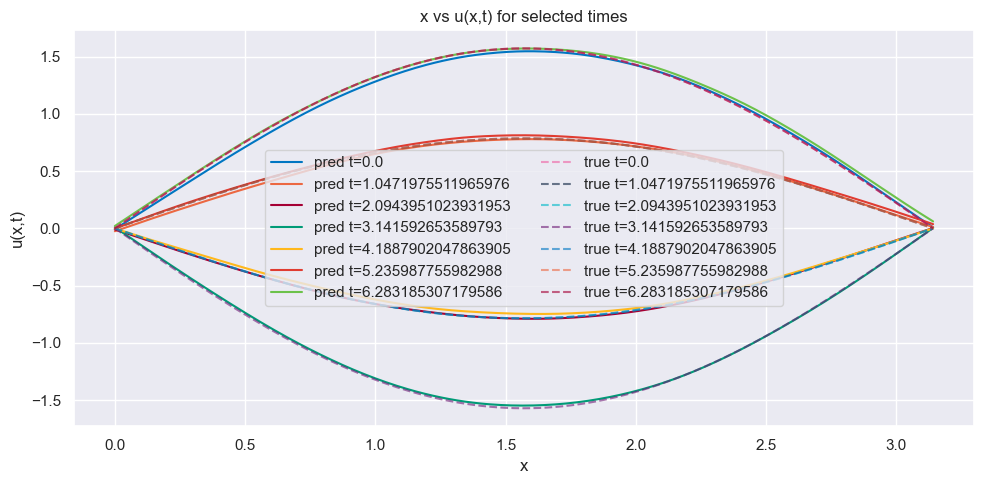

In [24]:
# Plot x vs u(x,t) for multiple time instants using the trained model

def plot_x_vs_u_at_times(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            '''
            # Model now outputs two values (u, theta), so take the first for u
            u_pred_output, _ = model(torch.cat([x, t], dim=1)).split(1, dim=-1)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output.squeeze().cpu()))
            '''
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            u_pred_output_norm, _ = model(torch.cat([x_norm, t_norm], dim=1)).split(1, dim=-1)
            u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, u_cpu in curves:
        plt.plot(x_cpu.numpy(), u_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if u(x,t) is defined above
    if with_exact and 'u_exact' in globals(): # Changed 'u' to 'u_exact' for clarity
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            u_true = u_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), u_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('x vs u(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Calculate the new time points: 0, T_end, and 5 evenly spaced times in between
num_times = 7 # 0, t_end, and 5 in between
new_times = np.linspace(0, t_end, num_times)

# Run the plot for default times
plot_x_vs_u_at_times(pinn, times=new_times, Nx =300, L_val=L, with_exact=True)

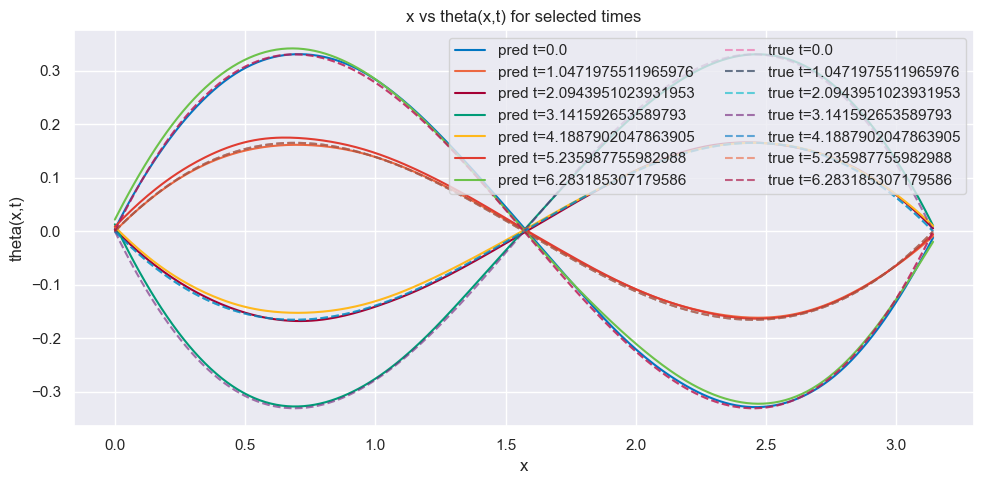

In [25]:
# Plot x vs theta(x,t) for multiple time instants using the trained model

def plot_x_vs_theta_at_times(model, times, Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            '''
            # Model now outputs two values (u, theta), so take the second for theta
            _, theta_pred_output = model(torch.cat([x, t], dim=1)).split(1, dim=-1)
            curves.append((t_val, x.squeeze().cpu(), theta_pred_output.squeeze().cpu()))
            '''
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            _, theta_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1)).split(1, dim=-1)
            theta_pred_output_denorm = theta_normalizer.denormalize(theta_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), theta_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, theta_cpu in curves:
        plt.plot(x_cpu.numpy(), theta_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if theta(x,t) is defined above
    if with_exact and 'theta_exact' in globals():
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            theta_true = theta_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), theta_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('theta(x,t)')
    plt.title('x vs theta(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Run the plot for theta
plot_x_vs_theta_at_times(pinn, times=new_times, Nx=300, L_val=L, with_exact=True)

In [26]:
x_array = np.linspace(0, np.pi, 10000)
t_array = np.linspace(0, 1, 10000)

'''
x_tensor = torch.tensor(x_array, dtype=torch.float32).view(-1, 1).to(device)
t_tensor = torch.tensor(t_array, dtype=torch.float32).view(-1, 1).to(device)
# Model now outputs two values (u, theta), so take the first for u
u_pred_output, _ = pinn(torch.cat([x_tensor, t_tensor], dim=1)).split(1, dim=-1)
u_pred = u_pred_output.cpu().detach().numpy()
u_exact_array = u_exact(x_tensor, t_tensor).cpu().detach().numpy()
R = np.linalg.norm(u_pred - u_exact_array) / np.linalg.norm(u_exact_array) * 100
'''

x_tensor = torch.tensor(x_array, dtype=torch.float32).view(-1, 1).to(device)
t_tensor = torch.tensor(t_array, dtype=torch.float32).view(-1, 1).to(device)
x_tensor_norm = x_normalizer.normalize(x_tensor)
t_tensor_norm = t_normalizer.normalize(t_tensor)
# Model now outputs two values (u, theta), so take the first for u
u_pred_output_norm, _ = pinn(torch.cat([x_tensor_norm, t_tensor_norm], dim=1)).split(1, dim=-1)
u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)
u_pred = u_pred_output_denorm.cpu().detach().numpy()
u_exact_array = u_exact(x_tensor, t_tensor).cpu().detach().numpy()
R = np.linalg.norm(u_pred - u_exact_array) / np.linalg.norm(u_exact_array) * 100

print(R)

2.32024397701025
